In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import time
from itertools import cycle
from kneed import KneeLocator
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
def create_datasets():
    """Create multiple synthetic datasets to demonstrate DBSCAN's capabilities."""
    datasets = []

    # Dataset 1: Two moons
    X1, y1 = make_moons(n_samples=500, noise=0.1, random_state=42)
    datasets.append(("Two Moons", X1, y1))

    # Dataset 2: Circles
    X2, y2 = make_circles(n_samples=500, noise=0.05, factor=0.5, random_state=42)
    datasets.append(("Circles", X2, y2))

    # Dataset 3: Blobs with different densities
    X3_1, y3_1 = make_blobs(n_samples=300, centers=[[0, 0]], cluster_std=0.2, random_state=42)
    X3_2, y3_2 = make_blobs(n_samples=100, centers=[[2.5, 0]], cluster_std=0.5, random_state=42)
    X3_3, y3_3 = make_blobs(n_samples=100, centers=[[0, 2.5]], cluster_std=0.8, random_state=42)

    X3 = np.vstack([X3_1, X3_2, X3_3])
    y3 = np.hstack([y3_1, y3_2 + 1, y3_3 + 2])
    datasets.append(("Varying Density Blobs", X3, y3))

    # Dataset 4: Noisy dataset with outliers
    X4, y4 = make_blobs(n_samples=400, centers=3, cluster_std=0.6, random_state=42)
    # Add some outliers
    outliers = np.random.uniform(low=-6, high=6, size=(50, 2))
    X4 = np.vstack([X4, outliers])
    y4 = np.hstack([y4, np.full(50, -1)])  # Marking outliers with -1
    datasets.append(("Blobs with Outliers", X4, y4))

    # Dataset 5: Anisotropic blobs
    X5, y5 = make_blobs(n_samples=500, centers=3, cluster_std=0.5, random_state=42)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X5 = np.dot(X5, transformation)
    datasets.append(("Anisotropic Blobs", X5, y5))

    return datasets

In [4]:
def plot_datasets(datasets):
    """Visualize the original datasets."""
    fig, axes = plt.subplots(1, len(datasets), figsize=(4*len(datasets), 4))

    for i, (name, X, y) in enumerate(datasets):
        ax = axes[i]
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7, s=30)
        ax.set_title(name)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

In [5]:
def find_optimal_eps(X, k=5):
    """
    Find an optimal epsilon value using the k-distance graph.

    Parameters:
    -----------
    X : array-like, shape=(n_samples, n_features)
        Input data
    k : int, optional (default=5)
        Number of nearest neighbors to consider

    Returns:
    --------
    eps : float
        Optimal epsilon value
    """
    # Compute distances to k nearest neighbors for each point
    neigh = NearestNeighbors(n_neighbors=k+1)  # +1 because the point itself is included
    neigh.fit(X)
    distances, indices = neigh.kneighbors(X)

    # Sort the distances to the kth nearest neighbor in ascending order
    k_distances = np.sort(distances[:, k])

    # Plot the k-distance graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(X)), k_distances, 'b-')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'Distance to {k}th nearest neighbor')
    plt.title('k-distance Graph')

    # Use the knee/elbow method to find the optimal epsilon
    # Try to find the "knee" or "elbow" in the curve
    try:
        kneedle = KneeLocator(range(len(X)), k_distances,
                              curve='convex', direction='increasing')
        knee_point = kneedle.knee
        if knee_point is not None:
            optimal_eps = k_distances[knee_point]
            plt.axvline(x=knee_point, color='r', linestyle='--',
                        label=f'Knee point: eps={optimal_eps:.2f}')
            plt.legend()
            print(f"Optimal eps value (at knee point): {optimal_eps:.4f}")
        else:
            # If knee detection fails, use a heuristic approach
            optimal_eps = np.percentile(k_distances, 90)
            plt.axhline(y=optimal_eps, color='g', linestyle='--',
                      label=f'Heuristic: eps={optimal_eps:.2f}')
            plt.legend()
            print(f"No clear knee found. Using heuristic eps value: {optimal_eps:.4f}")
    except:
        # Fallback to a simple heuristic if the KneeLocator fails
        optimal_eps = np.percentile(k_distances, 90)
        plt.axhline(y=optimal_eps, color='g', linestyle='--',
                  label=f'Heuristic: eps={optimal_eps:.2f}')
        plt.legend()
        print(f"Knee detection failed. Using heuristic eps value: {optimal_eps:.4f}")

    plt.grid(True)
    plt.show()

    return optimal_eps

In [6]:
def determine_min_samples(X, eps, k_range=range(2, 11)):
    """
    Determine a suitable min_samples parameter value for DBSCAN.

    Parameters:
    -----------
    X : array-like, shape=(n_samples, n_features)
        Input data
    eps : float
        Epsilon value for DBSCAN
    k_range : range, optional (default=range(2, 11))
        Range of min_samples values to try

    Returns:
    --------
    min_samples : int
        Recommended min_samples value
    """
    cluster_counts = []
    noise_counts = []
    silhouette_scores = []
    valid_k = []

    for k in k_range:
        # Run DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=k)
        labels = dbscan.fit_predict(X)

        # Count clusters and noise points
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        cluster_counts.append(n_clusters)
        noise_counts.append(n_noise / len(X) * 100)  # Percentage of noise

        # Calculate silhouette score if more than one cluster
        if n_clusters > 1:
            # Only calculate silhouette score for non-noise points
            if n_noise < len(X):
                mask = labels != -1
                score = silhouette_score(X[mask], labels[mask]) if len(set(labels[mask])) > 1 else 0
                silhouette_scores.append(score)
                valid_k.append(k)
            else:
                silhouette_scores.append(0)
                valid_k.append(k)
        else:
            silhouette_scores.append(0)
            valid_k.append(k)

    # Plot results
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('min_samples')
    ax1.set_ylabel('Number of Clusters', color='blue')
    ax1.plot(k_range, cluster_counts, 'b-', marker='o')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Noise Percentage', color='red')
    ax2.plot(k_range, noise_counts, 'r-', marker='s')
    ax2.tick_params(axis='y', labelcolor='red')

    # Add silhouette scores as annotations
    for i, (k, score) in enumerate(zip(valid_k, silhouette_scores)):
        ax1.annotate(f'{score:.2f}', (k, cluster_counts[k-k_range[0]]),
                    textcoords="offset points", xytext=(0,10), ha='center')

    plt.title('DBSCAN: Number of Clusters and Noise vs min_samples')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Find min_samples with highest silhouette score
    if max(silhouette_scores) > 0:
        best_k = valid_k[np.argmax(silhouette_scores)]
        print(f"Recommended min_samples based on highest silhouette score: {best_k}")
        print(f"Resulting in {cluster_counts[best_k-k_range[0]]} clusters and {noise_counts[best_k-k_range[0]]:.1f}% noise")
        return best_k
    else:
        # Heuristic: balance between number of clusters and noise percentage
        # Aim for not too many clusters and not too much noise
        scores = [(k, c, n) for k, c, n in zip(k_range, cluster_counts, noise_counts)
                 if c >= 2 and n < 30]  # At least 2 clusters, less than 30% noise

        if scores:
            # Sort by noise (lower is better) as a tie-breaker
            scores.sort(key=lambda x: (abs(x[1]-3), x[2]))  # Prefer around 3 clusters
            best_k = scores[0][0]
            print(f"Recommended min_samples based on heuristic: {best_k}")
            print(f"Resulting in {cluster_counts[best_k-k_range[0]]} clusters and {noise_counts[best_k-k_range[0]]:.1f}% noise")
            return best_k
        else:
            # Default to a common choice
            print("Couldn't determine optimal min_samples. Using default value of 5.")
            return 5

In [7]:
def run_dbscan(X, eps, min_samples):
    """
    Run DBSCAN algorithm and return labels and performance metrics.

    Parameters:
    -----------
    X : array-like, shape=(n_samples, n_features)
        Input data
    eps : float
        The maximum distance between two samples for them to be considered as in the same neighborhood
    min_samples : int
        The number of samples in a neighborhood for a point to be considered as a core point

    Returns:
    --------
    labels : array, shape=(n_samples,)
        Cluster labels for each point
    metrics : dict
        Dictionary containing performance metrics
    """
    # Start timer
    start_time = time.time()

    # Run DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)

    # End timer
    end_time = time.time()
    runtime = end_time - start_time

    # Calculate metrics
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    noise_percentage = n_noise / len(X) * 100

    # Calculate silhouette score if more than one cluster and not all points are noise
    silhouette = None
    if n_clusters > 1 and n_noise < len(X):
        mask = labels != -1
        if len(set(labels[mask])) > 1:  # Ensure there are at least two clusters without noise
            silhouette = silhouette_score(X[mask], labels[mask])

    metrics = {
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_percentage': noise_percentage,
        'silhouette_score': silhouette,
        'runtime': runtime
    }

    return labels, metrics

In [8]:
def plot_dbscan_results(X, labels, metrics, title="DBSCAN Clustering Results"):
    """
    Visualize the DBSCAN clustering results.

    Parameters:
    -----------
    X : array-like, shape=(n_samples, n_features)
        Input data
    labels : array, shape=(n_samples,)
        Cluster labels for each point
    metrics : dict
        Dictionary containing performance metrics
    title : str, optional (default="DBSCAN Clustering Results")
        Plot title
    """
    # Generate a colormap
    n_clusters = metrics['n_clusters']
    colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

    # Create plot
    plt.figure(figsize=(10, 6))

    # Plot noise points first
    noise_mask = labels == -1
    if np.any(noise_mask):
        plt.scatter(X[noise_mask, 0], X[noise_mask, 1], c='black', marker='x', s=30,
                    alpha=0.5, label='Noise')

    # Plot clusters
    for k, color in zip(range(n_clusters), colors):
        cluster_mask = labels == k
        plt.scatter(X[cluster_mask, 0], X[cluster_mask, 1], c=color, marker='o', s=50,
                    alpha=0.7, label=f'Cluster {k}')

    # Add metrics to the plot
    info_str = (f"Clusters: {metrics['n_clusters']}\n"
                f"Noise: {metrics['n_noise']} points ({metrics['noise_percentage']:.1f}%)\n")

    if metrics['silhouette_score'] is not None:
        info_str += f"Silhouette: {metrics['silhouette_score']:.3f}\n"

    info_str += f"Runtime: {metrics['runtime']:.3f} seconds"

    plt.annotate(info_str, xy=(0.02, 0.02), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [9]:
def compare_parameters(X, eps_values, min_samples_values):
    """
    Compare DBSCAN performance with different parameter combinations.

    Parameters:
    -----------
    X : array-like, shape=(n_samples, n_features)
        Input data
    eps_values : array-like
        List of epsilon values to try
    min_samples_values : array-like
        List of min_samples values to try
    """
    # Create a grid of subplots
    rows = len(min_samples_values)
    cols = len(eps_values)
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

    # Store metrics for later comparison
    all_metrics = np.zeros((rows, cols, 4))  # [n_clusters, noise_percentage, silhouette, runtime]

    # Run DBSCAN for each parameter combination
    for i, min_samples in enumerate(min_samples_values):
        for j, eps in enumerate(eps_values):
            # Run DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)

            # Calculate metrics
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            noise_percentage = n_noise / len(X) * 100

            # Calculate silhouette score if applicable
            silhouette = np.nan
            if n_clusters > 1 and n_noise < len(X):
                mask = labels != -1
                if len(set(labels[mask])) > 1:
                    silhouette = silhouette_score(X[mask], labels[mask])

            # Store metrics
            all_metrics[i, j, 0] = n_clusters
            all_metrics[i, j, 1] = noise_percentage
            all_metrics[i, j, 2] = silhouette

            # Get axis (handle both single and multi-dimensional cases)
            if rows == 1 and cols == 1:
                ax = axes
            elif rows == 1:
                ax = axes[j]
            elif cols == 1:
                ax = axes[i]
            else:
                ax = axes[i, j]

            # Plot clusters
            noise_mask = labels == -1
            if np.any(noise_mask):
                ax.scatter(X[noise_mask, 0], X[noise_mask, 1], c='black', marker='x', s=10, alpha=0.3)

            for k in range(n_clusters):
                cluster_mask = labels == k
                ax.scatter(X[cluster_mask, 0], X[cluster_mask, 1], s=20, alpha=0.6)

            # Add parameter info and metrics
            title = f"eps={eps:.2f}, min_samples={min_samples}"
            info = f"C:{n_clusters}, N:{noise_percentage:.1f}%"
            if not np.isnan(silhouette):
                info += f", S:{silhouette:.2f}"

            ax.set_title(title, fontsize=10)
            ax.text(0.5, 0.02, info, transform=ax.transAxes,
                   fontsize=8, ha='center',
                   bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7))

            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()

    # Display heatmaps of the metrics
    metric_names = ['Number of Clusters', 'Noise Percentage', 'Silhouette Score']

    for m, metric_name in enumerate(metric_names):
        plt.figure(figsize=(10, 6))

        # Create heatmap
        if m == 2:  # Special handling for silhouette score
            # Replace NaNs with minimum value for visualization purposes
            metric_data = all_metrics[:, :, m].copy()
            mask = np.isnan(metric_data)
            metric_data[mask] = -1  # Use -1 to distinguish from valid low scores

            # Create a custom colormap that shows NaNs differently
            cmap = plt.cm.viridis.copy()
            cmap.set_bad('white')

            # Create heatmap with a mask for NaN values
            sns.heatmap(metric_data, annot=True, fmt=".2f", cmap=cmap,
                      xticklabels=[f"{e:.2f}" for e in eps_values],
                      yticklabels=min_samples_values,
                      mask=mask)

            # Overlay a different color for NaN values
            sns.heatmap(np.ones_like(metric_data) * -1, mask=~mask, cmap=['lightgrey'],
                      annot=mask, fmt="", cbar=False)

        else:
            sns.heatmap(all_metrics[:, :, m], annot=True,
                      fmt=".1f" if m == 1 else ".0f",  # Format based on metric type
                      cmap='viridis',
                      xticklabels=[f"{e:.2f}" for e in eps_values],
                      yticklabels=min_samples_values)

        plt.xlabel('Epsilon')
        plt.ylabel('Min Samples')
        plt.title(f'{metric_name} for Different DBSCAN Parameters')
        plt.tight_layout()
        plt.show()

    # Identify best parameter combinations
    # For clusters, we want a reasonable number (not too many, not too few)
    # For noise, we want a low percentage but not zero (which might indicate overfitting)
    # For silhouette, we want a high score

    # Create a composite score (heuristic)
    composite_scores = np.zeros((rows, cols))

    for i in range(rows):
        for j in range(cols):
            n_clusters = all_metrics[i, j, 0]
            noise_pct = all_metrics[i, j, 1]
            silhouette = all_metrics[i, j, 2]

            # Skip if no meaningful clustering was found
            if n_clusters <= 1 or np.isnan(silhouette):
                composite_scores[i, j] = -np.inf
                continue

            # Penalize too many or too few clusters
            cluster_score = 0
            if 2 <= n_clusters <= 5:  # Preferred range
                cluster_score = 1.0
            else:
                cluster_score = 1.0 / (1 + abs(n_clusters - 3))  # Penalty increases with distance from 3

            # Penalize too much noise
            noise_score = 1.0 - min(1.0, noise_pct / 50)  # 50% noise or more is worst

            # Weight silhouette score (higher is better)
            _silhouette_score = max(0, silhouette)  # Ensure non-negative

            # Combine scores (equal weights)
            composite_scores[i, j] = (cluster_score + noise_score + _silhouette_score) / 3

    # Find best parameter combinations
    if np.max(composite_scores) > -np.inf:
        best_idx = np.unravel_index(np.argmax(composite_scores), composite_scores.shape)
        best_min_samples = min_samples_values[best_idx[0]]
        best_eps = eps_values[best_idx[1]]

        print("Best parameter combination based on composite score:")
        print(f"eps = {best_eps:.4f}, min_samples = {best_min_samples}")
        print(f"Number of clusters: {all_metrics[best_idx[0], best_idx[1], 0]:.0f}")
        print(f"Noise percentage: {all_metrics[best_idx[0], best_idx[1], 1]:.1f}%")
        print(f"Silhouette score: {all_metrics[best_idx[0], best_idx[1], 2]:.3f}")
    else:
        print("No good parameter combination found. Try different values.")

In [10]:
def apply_dbscan_to_real_data():
    """Apply DBSCAN to a real-world dataset: Wholesale customers dataset."""
    # Load the dataset
    try:
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
        df = pd.read_csv(url)
        print("Successfully loaded the Wholesale Customers dataset")
    except:
        # Fallback to creating the dataset manually if download fails
        print("Failed to download dataset. Creating a synthetic version for demonstration.")
        # Create a synthetic dataset similar to Wholesale customers
        n_samples = 440
        n_features = 6
        centers = [[300, 400, 100, 50, 20, 80],
                  [100, 100, 300, 150, 30, 100],
                  [200, 200, 200, 100, 50, 50]]
        X_synthetic, _ = make_blobs(n_samples=n_samples, n_features=n_features,
                                  centers=centers, random_state=42, cluster_std=50)

        feature_names = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']
        df = pd.DataFrame(X_synthetic, columns=feature_names)
        # Add a Channel column (similar to the real dataset)
        df['Channel'] = np.random.choice([1, 2], size=n_samples, p=[0.6, 0.4])
        df['Region'] = np.random.choice([1, 2, 3], size=n_samples)

    # Display dataset information
    print("\nDataset Information:")
    print(f"Shape: {df.shape}")
    print("\nFeature Statistics:")
    print(df.describe().round(2))

    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("\nMissing Values:")
        print(missing_values[missing_values > 0])
        # Fill or drop missing values as appropriate
        df = df.dropna()
    else:
        print("\nNo missing values found.")

    # Select features for clustering (exclude categorical features)
    if 'Channel' in df.columns and 'Region' in df.columns:
        X = df.drop(['Channel', 'Region'], axis=1).values
        # Keep these for later analysis
        channel = df['Channel'].values
        region = df['Region'].values
    else:
        X = df.values
        channel = None
        region = None

    # Standardize the data
    print("\nStandardizing the data...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Find optimal parameters
    print("\nFinding optimal DBSCAN parameters...")
    optimal_eps = find_optimal_eps(X_scaled)
    optimal_min_samples = determine_min_samples(X_scaled, optimal_eps)

    # Run DBSCAN with optimal parameters
    print("\nRunning DBSCAN with optimal parameters...")
    labels, metrics = run_dbscan(X_scaled, optimal_eps, optimal_min_samples)

    # Visualize results in 2D using t-SNE for dimensionality reduction
    print("\nVisualizing DBSCAN results with t-SNE...")
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    # Plot DBSCAN results in t-SNE space
    plt.figure(figsize=(12, 10))

    # Plot points colored by cluster
    plt.subplot(2, 2, 1)
    noise_mask = labels == -1
    plt.scatter(X_tsne[noise_mask, 0], X_tsne[noise_mask, 1], c='black', marker='x', s=30,
                alpha=0.5, label='Noise')

    # Plot clusters
    for k in range(metrics['n_clusters']):
        cluster_mask = labels == k
        plt.scatter(X_tsne[cluster_mask, 0], X_tsne[cluster_mask, 1], s=50, alpha=0.7, label=f'Cluster {k}')

    plt.title('DBSCAN Clustering Results (t-SNE projection)')
    plt.legend()

    # If we have Channel information, visualize that as well
    if channel is not None:
        plt.subplot(2, 2, 2)
        for i, ch_name in enumerate(['Channel 1', 'Channel 2']):
            mask = channel == i + 1
            plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], s=50, alpha=0.7, label=ch_name)

        plt.title('Distribution by Channel (t-SNE projection)')
        plt.legend()

    # If we have Region information, visualize that as well
    if region is not None:
        plt.subplot(2, 2, 3)
        for i, reg_name in enumerate(['Region 1', 'Region 2', 'Region 3']):
            mask = region == i + 1
            plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], s=50, alpha=0.7, label=reg_name)

        plt.title('Distribution by Region (t-SNE projection)')
        plt.legend()

    # Add the cluster distribution
    plt.subplot(2, 2, 4)
    cluster_counts = np.bincount(labels[labels != -1] if -1 in labels else labels)
    plt.bar(range(len(cluster_counts)), cluster_counts, alpha=0.7)
    plt.xlabel('Cluster')
    plt.ylabel('Number of points')
    plt.title('Cluster Size Distribution')

    if -1 in labels:
        plt.text(0.5, 0.9, f"Noise points: {list(labels).count(-1)}",
                transform=plt.gca().transAxes, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Analyze the clusters
    print("\nCluster Analysis:")
    cluster_df = pd.DataFrame(X, columns=df.columns if 'Channel' not in df.columns
                             else df.drop(['Channel', 'Region'], axis=1).columns)
    cluster_df['Cluster'] = labels

    # Calculate mean values for each cluster
    print("\nCluster Means:")
    cluster_means = cluster_df.groupby('Cluster').mean().round(2)
    print(cluster_means)

    # Visualize feature distributions across clusters
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(cluster_df.columns[:-1]):
        plt.subplot(3, 2, i+1)
        for cluster in sorted(set(labels)):
            if cluster == -1:
                label = 'Noise'
            else:
                label = f'Cluster {cluster}'

            data = cluster_df[cluster_df['Cluster'] == cluster][feature]
            sns.kdeplot(data, label=label, fill=True, alpha=0.3)

        plt.title(f'Distribution of {feature} by Cluster')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.tight_layout()
        plt.legend()
        plt.show()

     # If we have channel information, analyze cluster composition
    if channel is not None:
        print("\nChannel Distribution within Clusters:")
        cluster_df['Channel'] = channel
        channel_distribution = pd.crosstab(cluster_df['Cluster'], cluster_df['Channel'],
                                         normalize='index') * 100
        print(channel_distribution.round(2))

        # Visualize channel distribution
        plt.figure(figsize=(10, 6))
        channel_distribution.plot(kind='bar', stacked=True)
        plt.xlabel('Cluster')
        plt.ylabel('Percentage')
        plt.title('Channel Distribution within Clusters')
        plt.legend(title='Channel')
        plt.tight_layout()
        plt.show()

    # If we have region information, analyze cluster composition
    if region is not None:
        print("\nRegion Distribution within Clusters:")
        cluster_df['Region'] = region
        region_distribution = pd.crosstab(cluster_df['Cluster'], cluster_df['Region'],
                                        normalize='index') * 100
        print(region_distribution.round(2))

        # Visualize region distribution
        plt.figure(figsize=(10, 6))
        region_distribution.plot(kind='bar', stacked=True)
        plt.xlabel('Cluster')
        plt.ylabel('Percentage')
        plt.title('Region Distribution within Clusters')
        plt.legend(title='Region')
        plt.tight_layout()
        plt.show()

    # Visualize cluster characteristics using a heatmap
    plt.figure(figsize=(12, 8))
    cluster_means_normalized = scaler.inverse_transform(
        cluster_means.loc[[c for c in cluster_means.index if c != -1]].values
    )
    cluster_means_df = pd.DataFrame(
        cluster_means_normalized,
        columns=cluster_means.columns,
        index=[f'Cluster {i}' for i in cluster_means.index if i != -1]
    )

    # Add noise if present
    if -1 in cluster_means.index:
        noise_means = scaler.inverse_transform(cluster_means.loc[[-1]].values)
        noise_df = pd.DataFrame(noise_means, columns=cluster_means.columns, index=['Noise'])
        cluster_means_df = pd.concat([cluster_means_df, noise_df])

    # Create a heatmap
    sns.heatmap(cluster_means_df, annot=True, fmt='.0f', cmap='viridis')
    plt.title('Cluster Characteristics (Mean Values)')
    plt.tight_layout()
    plt.show()

    return labels, metrics

In [11]:
def dbscan_main():
    """Main function to demonstrate DBSCAN clustering."""
    print("=" * 80)
    print("COMPREHENSIVE DBSCAN CLUSTERING IMPLEMENTATION")
    print("=" * 80)

    # 1. Create and visualize synthetic datasets
    print("\n1. SYNTHETIC DATASETS DEMONSTRATION")
    print("-" * 50)
    datasets = create_datasets()
    plot_datasets(datasets)

    # 2. Apply DBSCAN to each synthetic dataset
    print("\n2. APPLYING DBSCAN TO SYNTHETIC DATASETS")

    for name, X, y_true in datasets:
        print("\n" + "-" * 50)
        print(f"Dataset: {name}")
        print("-" * 50)

        # Standardize data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Find optimal parameters
        print("\nFinding optimal epsilon using k-distance graph:")
        optimal_eps = find_optimal_eps(X_scaled)

        print("\nDetermining optimal min_samples parameter:")
        optimal_min_samples = determine_min_samples(X_scaled, optimal_eps)

        # Run DBSCAN with optimal parameters
        print("\nRunning DBSCAN with optimal parameters:")
        labels, metrics = run_dbscan(X_scaled, optimal_eps, optimal_min_samples)

        # Visualize results
        print("\nDBSCAN clustering results:")
        plot_dbscan_results(X, labels, metrics, f"DBSCAN Results: {name}")

        # Evaluate clustering against true labels if available
        if y_true is not None:
            # Calculate ARI (Adjusted Rand Index)
            ari = adjusted_rand_score(y_true, labels)
            print(f"\nAdjusted Rand Index (compared to ground truth): {ari:.4f}")

            # Visualize ground truth vs. DBSCAN clusters
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            scatter = plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', s=50, alpha=0.7)
            plt.title('Ground Truth')
            plt.colorbar(scatter)

            plt.subplot(1, 2, 2)
            scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
            plt.title('DBSCAN Clusters')
            plt.colorbar(scatter)

            plt.tight_layout()
            plt.show()

        # Parameter sensitivity analysis
        print("\nParameter sensitivity analysis:")
        eps_range = np.linspace(optimal_eps * 0.5, optimal_eps * 1.5, 4)
        min_samples_range = [max(2, optimal_min_samples - 2), optimal_min_samples,
                            optimal_min_samples + 2, optimal_min_samples + 4]

        compare_parameters(X_scaled, eps_range, min_samples_range)

    # 3. Apply DBSCAN to a real-world dataset
    print("\n" + "=" * 50)
    print("3. APPLYING DBSCAN TO A REAL-WORLD DATASET")
    print("=" * 50)
    apply_dbscan_to_real_data()

    # 4. Summary and conclusions
    print("\n" + "=" * 50)
    print("4. DBSCAN SUMMARY AND CONCLUSIONS")
    print("=" * 50)
    print("\nAdvantages of DBSCAN:")
    print("- Does not require specifying the number of clusters beforehand")
    print("- Can find arbitrarily shaped clusters")
    print("- Robust to outliers (marks them as noise)")
    print("- Works well when clusters have varying densities (with appropriate parameters)")

    print("\nLimitations of DBSCAN:")
    print("- Sensitive to parameter selection (eps and min_samples)")
    print("- May struggle with clusters of varying densities")
    print("- Curse of dimensionality affects distance measurements")
    print("- Not ideal for high-dimensional data without dimensionality reduction")

    print("\nBest practices for DBSCAN:")
    print("1. Standardize or normalize your data before clustering")
    print("2. Use the k-distance graph to help identify an appropriate eps value")
    print("3. Set min_samples to at least the dimensionality of the data + 1")
    print("4. For high-dimensional data, consider dimensionality reduction first")
    print("5. Evaluate clustering quality with silhouette score or domain knowledge")

    print("\nThank you for using the comprehensive DBSCAN implementation!")
    print("=" * 80)


COMPREHENSIVE DBSCAN CLUSTERING IMPLEMENTATION

1. SYNTHETIC DATASETS DEMONSTRATION
--------------------------------------------------


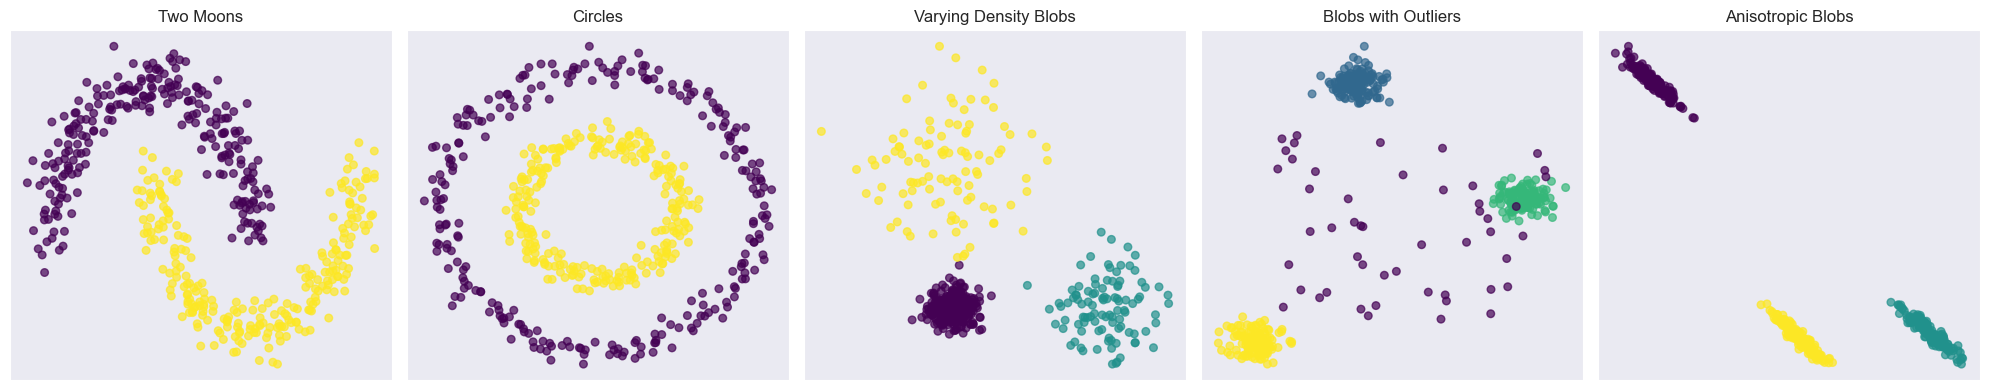


2. APPLYING DBSCAN TO SYNTHETIC DATASETS

--------------------------------------------------
Dataset: Two Moons
--------------------------------------------------

Finding optimal epsilon using k-distance graph:
Optimal eps value (at knee point): 0.2323


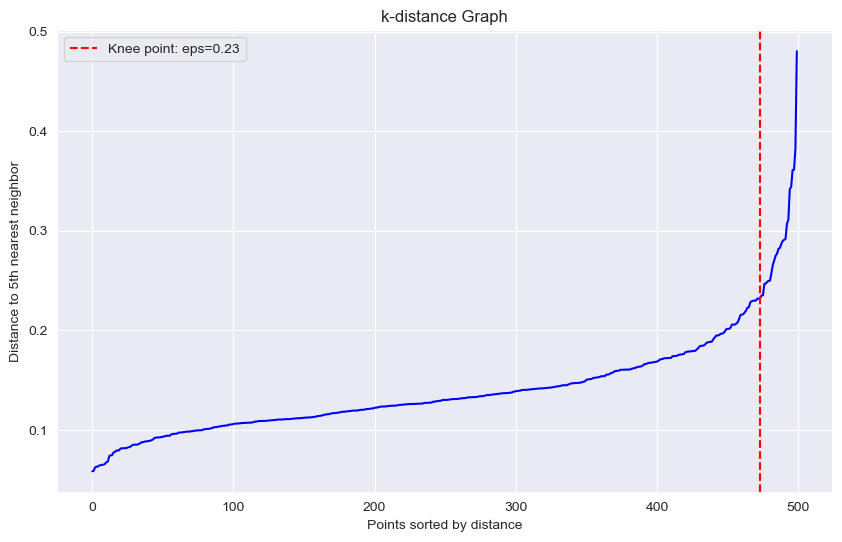


Determining optimal min_samples parameter:


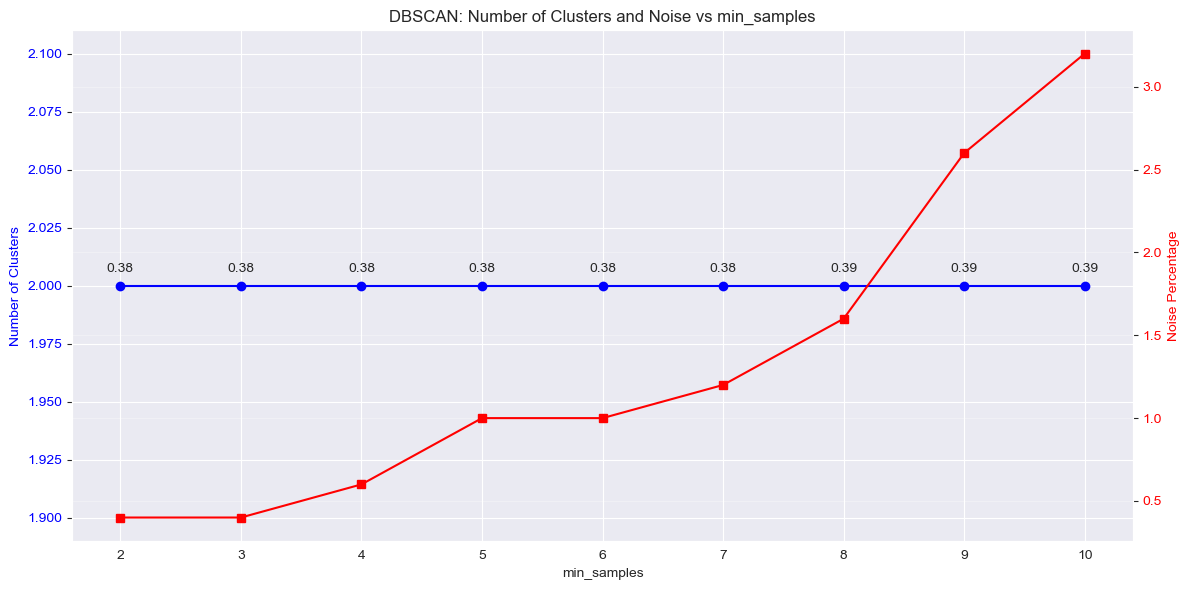

Recommended min_samples based on highest silhouette score: 10
Resulting in 2 clusters and 3.2% noise

Running DBSCAN with optimal parameters:

DBSCAN clustering results:


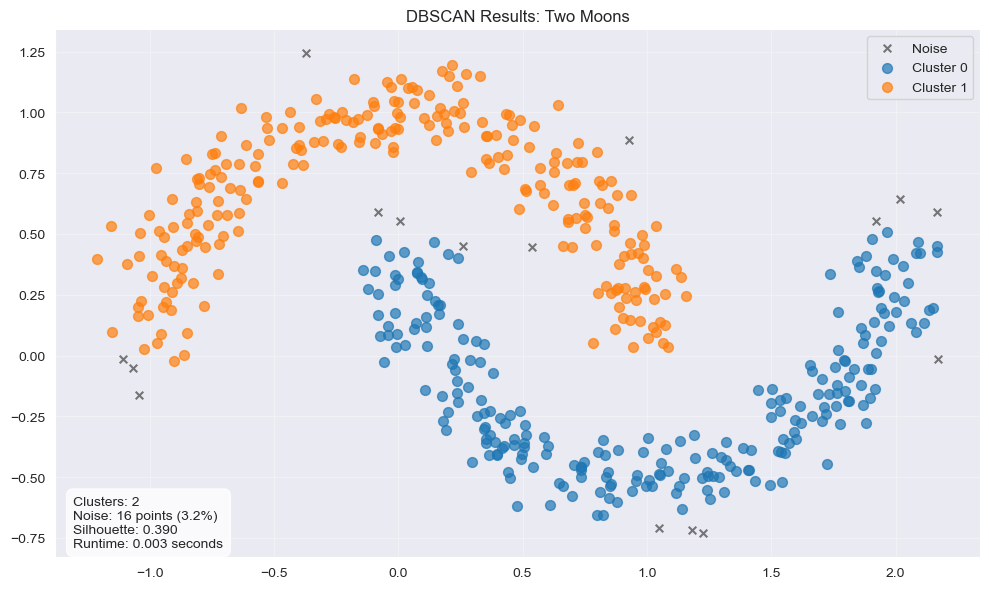


Adjusted Rand Index (compared to ground truth): 0.9371


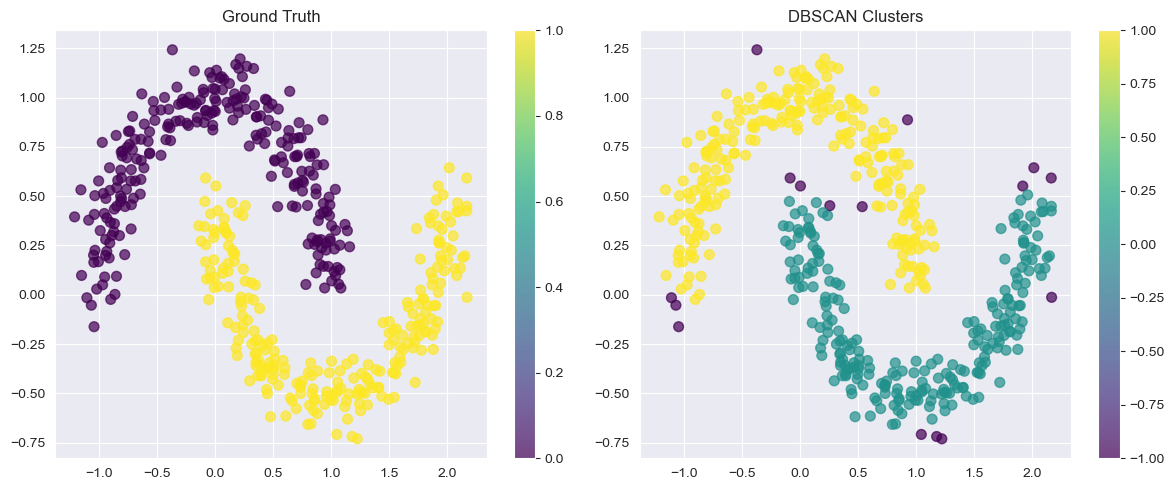


Parameter sensitivity analysis:


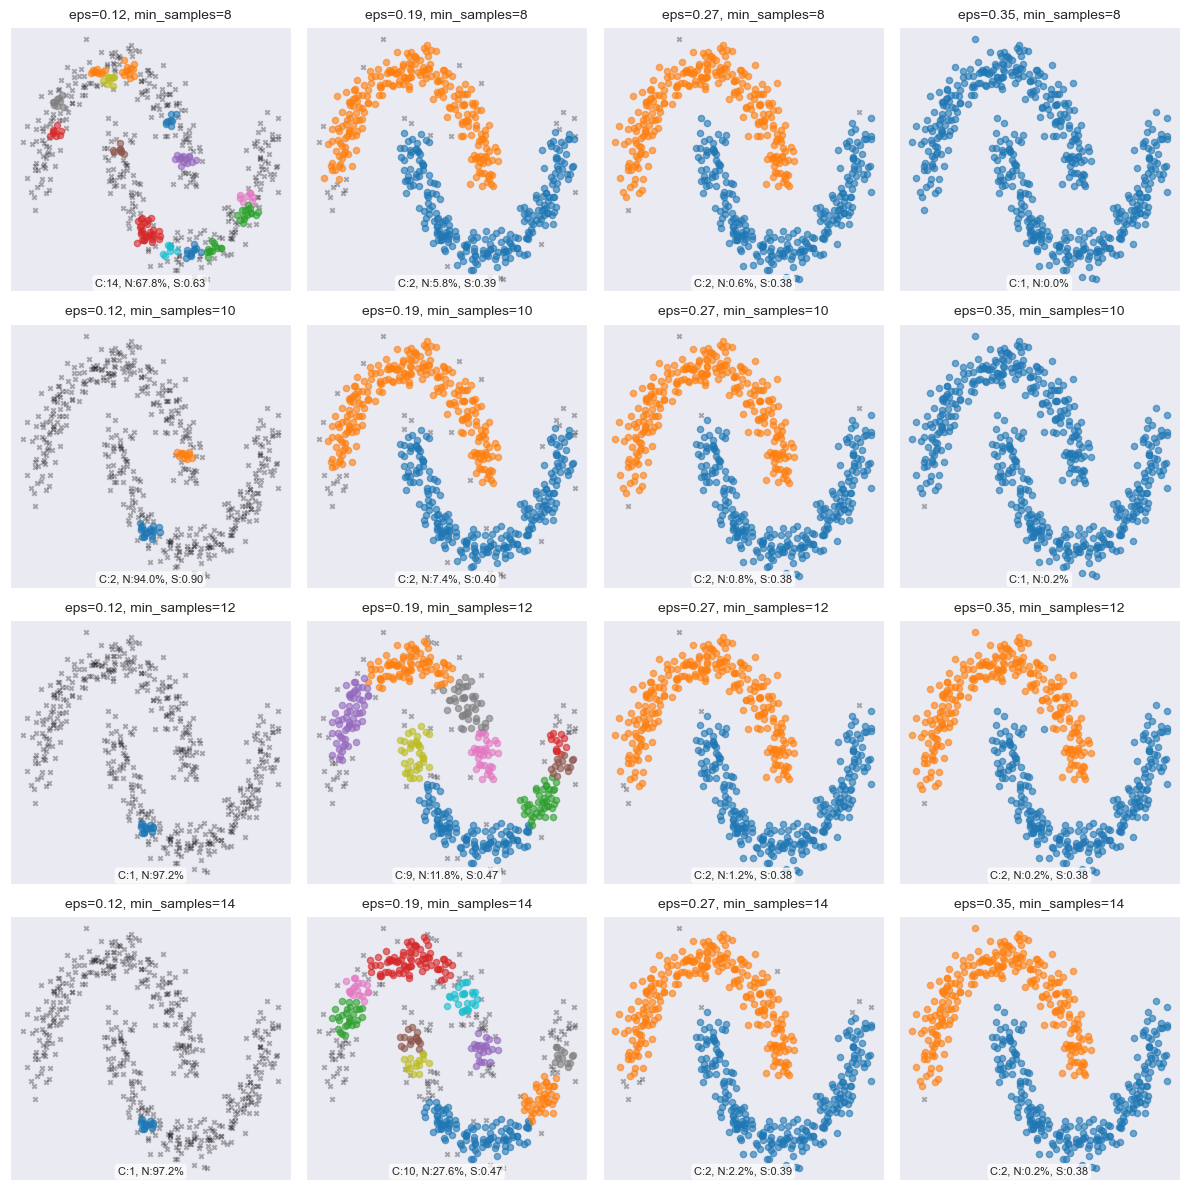

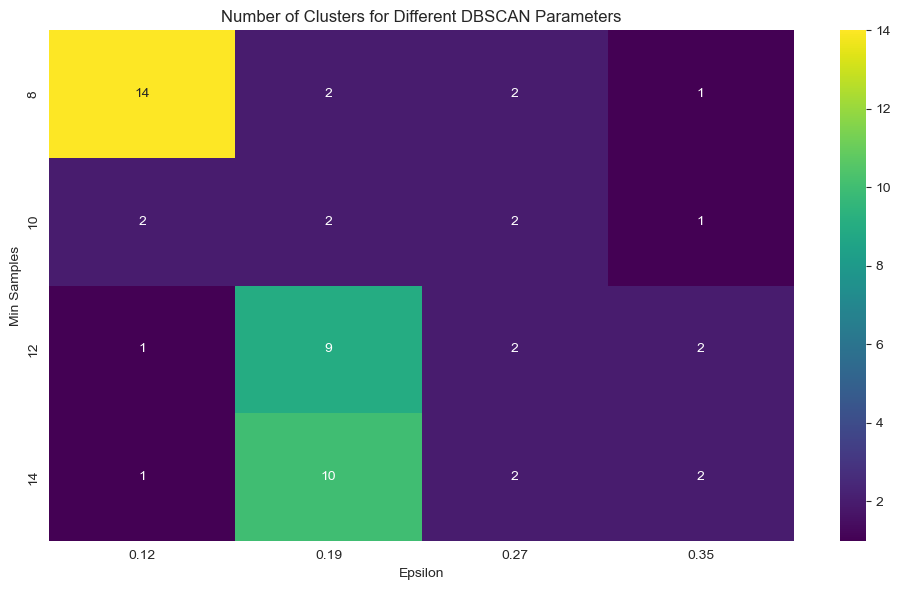

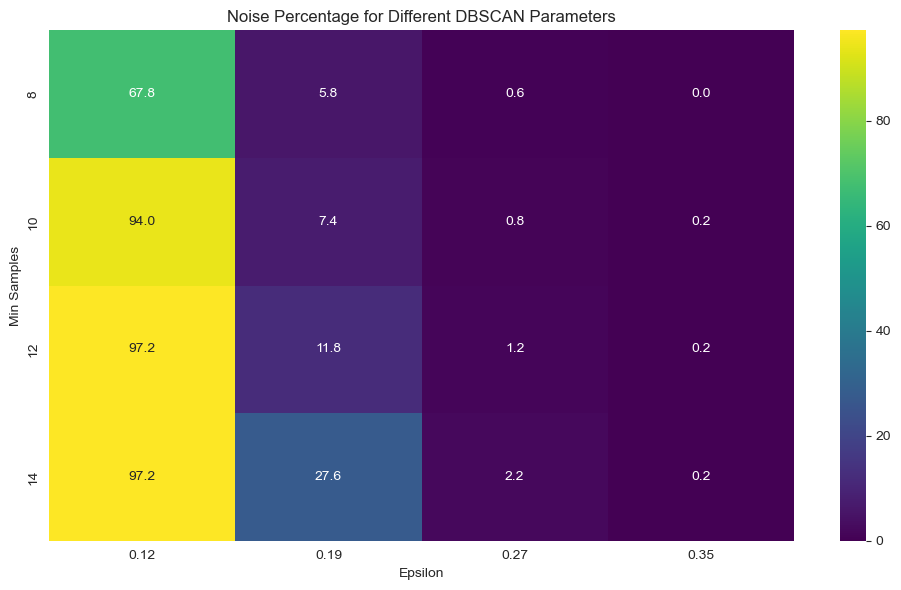

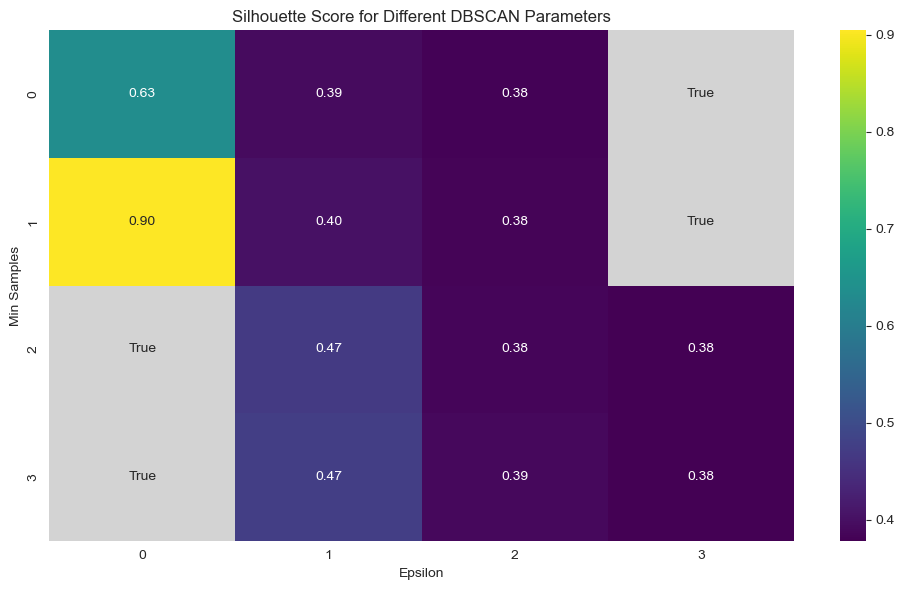

Best parameter combination based on composite score:
eps = 0.3485, min_samples = 14
Number of clusters: 2
Noise percentage: 0.2%
Silhouette score: 0.380

--------------------------------------------------
Dataset: Circles
--------------------------------------------------

Finding optimal epsilon using k-distance graph:
Optimal eps value (at knee point): 0.2427


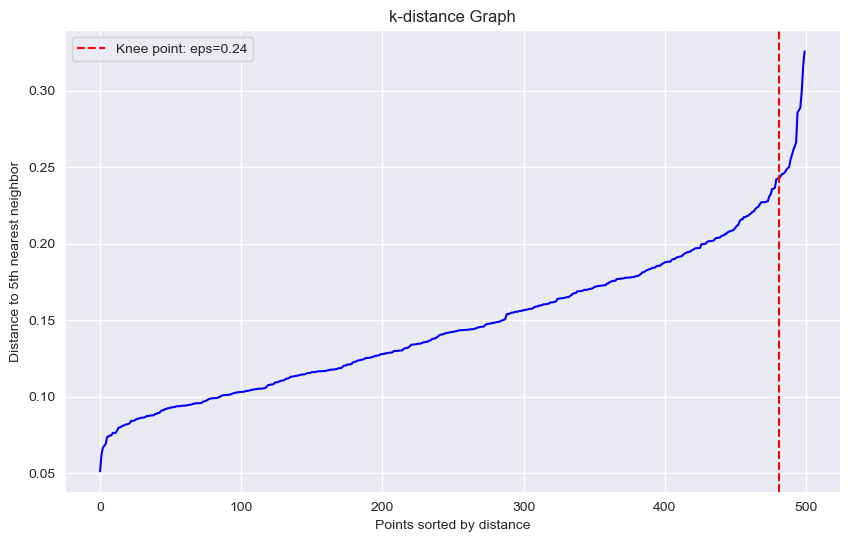


Determining optimal min_samples parameter:


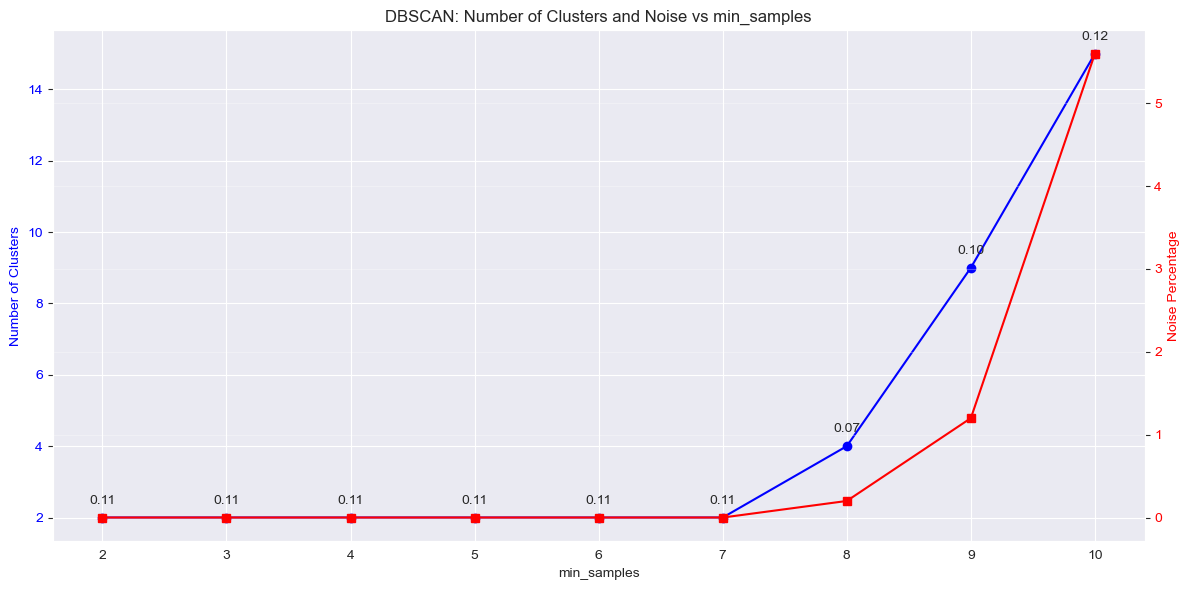

Recommended min_samples based on highest silhouette score: 10
Resulting in 15 clusters and 5.6% noise

Running DBSCAN with optimal parameters:

DBSCAN clustering results:


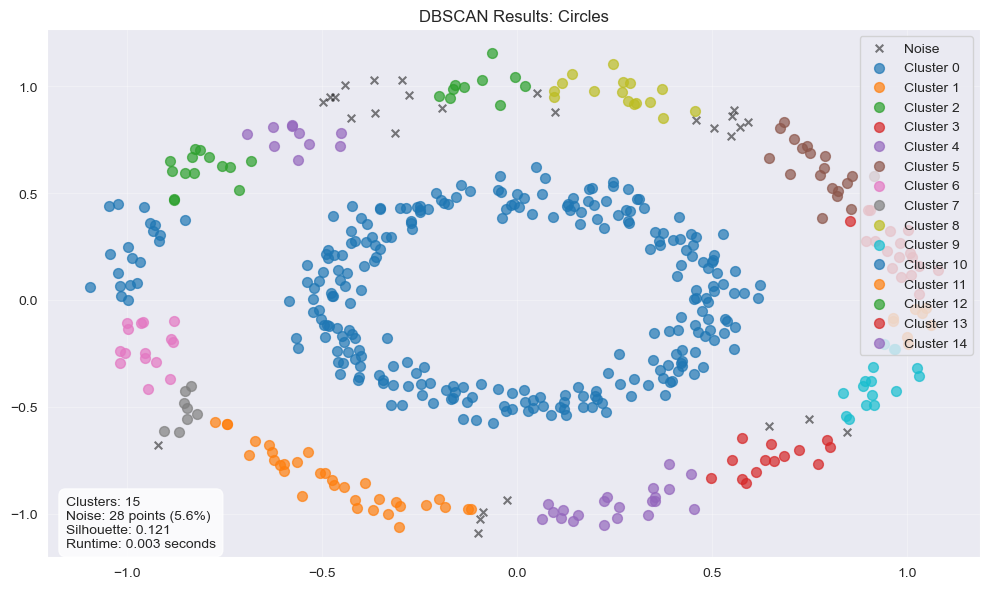


Adjusted Rand Index (compared to ground truth): 0.5375


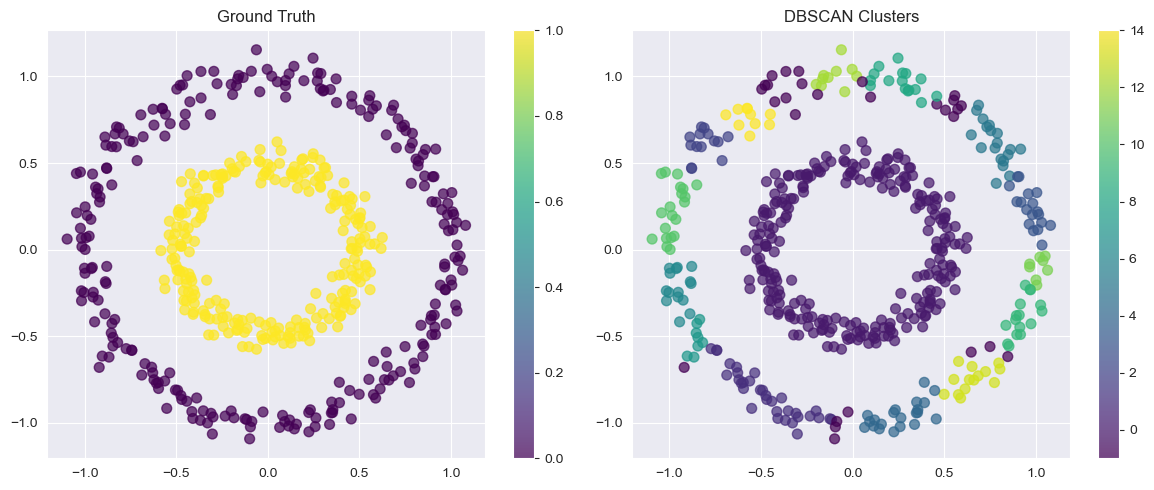


Parameter sensitivity analysis:


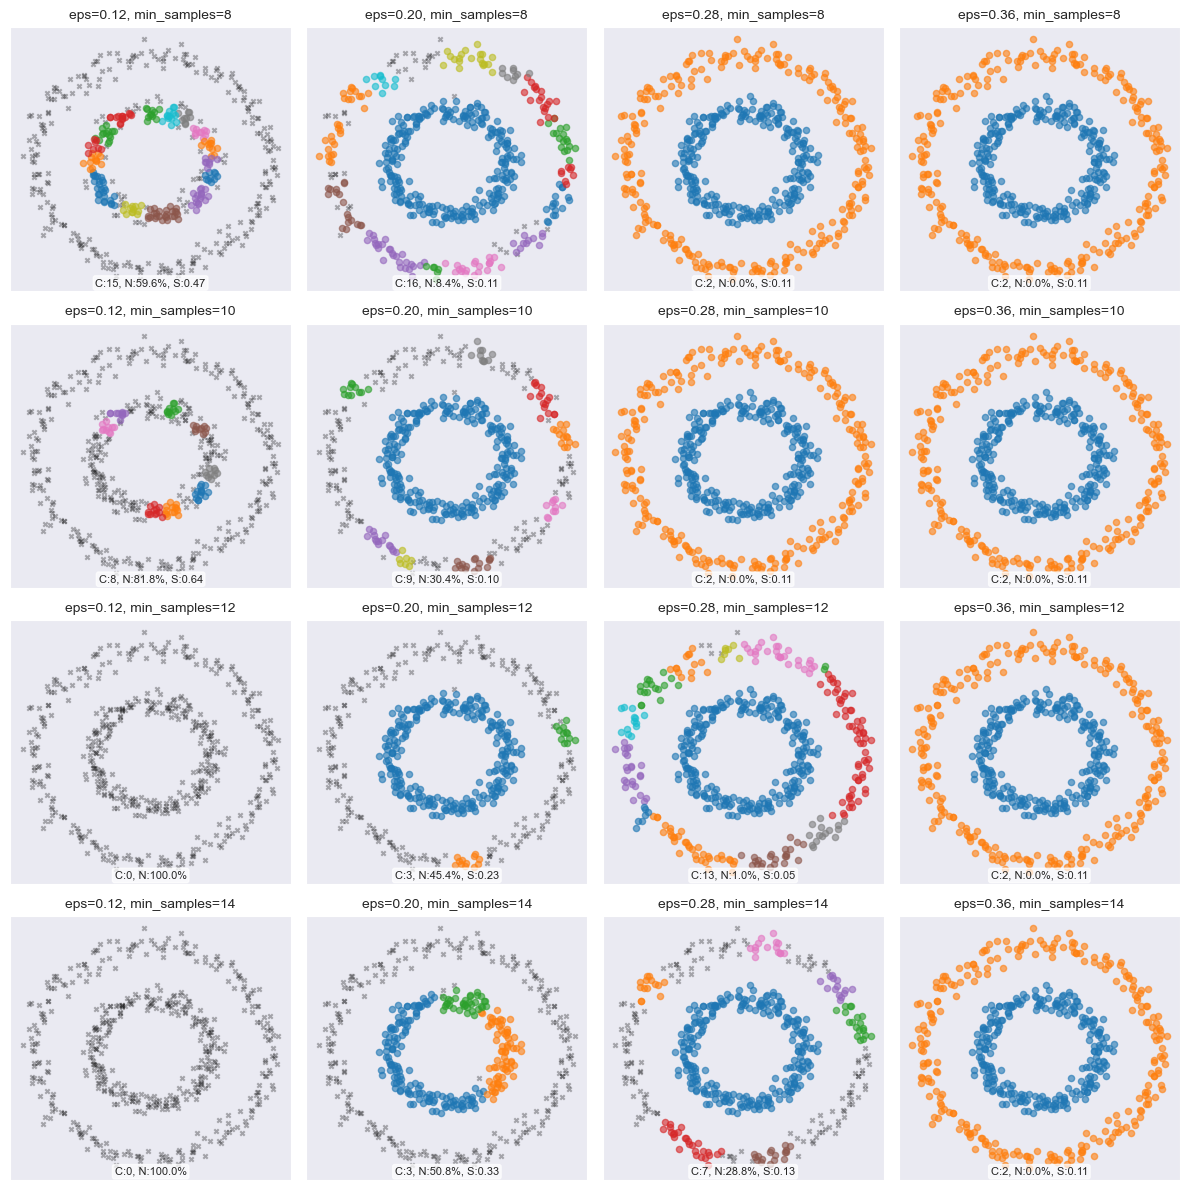

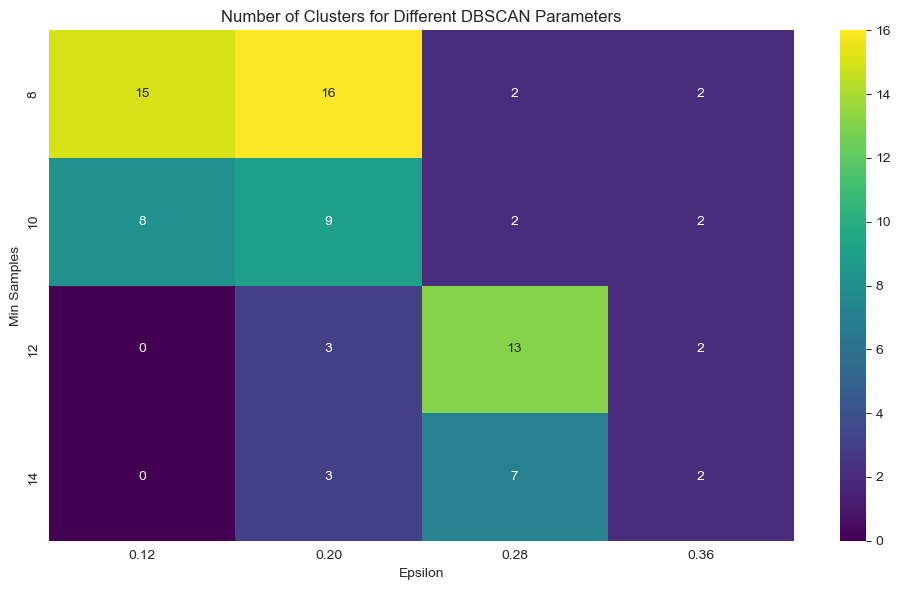

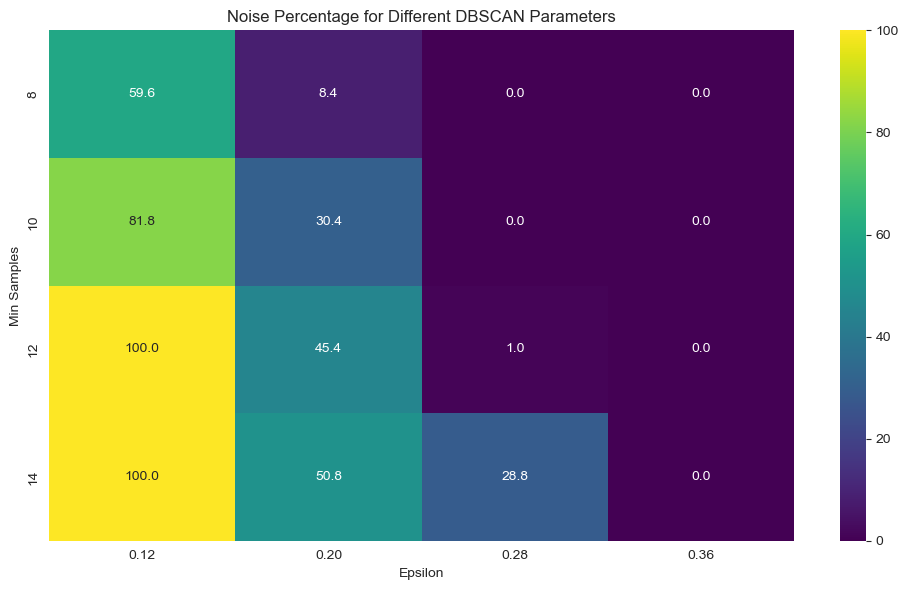

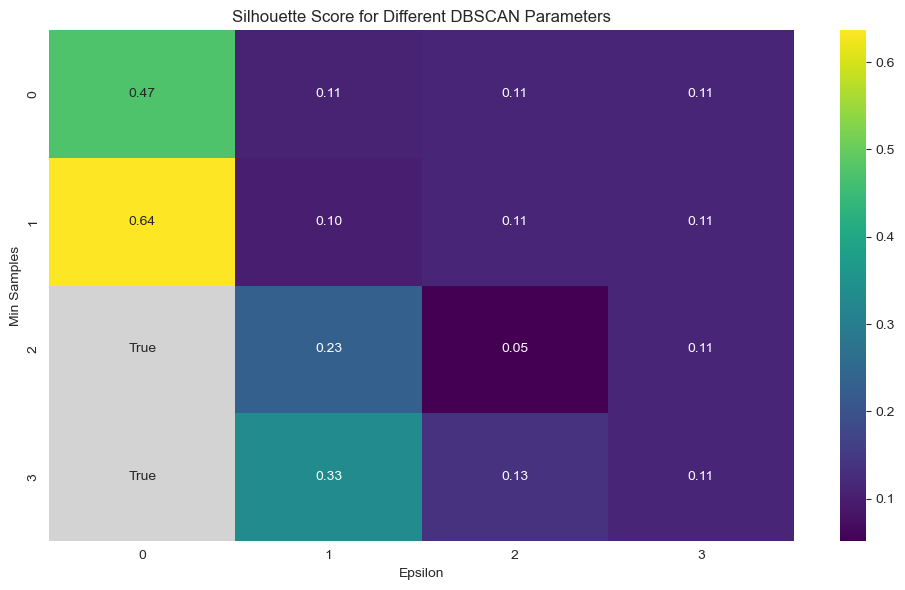

Best parameter combination based on composite score:
eps = 0.2831, min_samples = 8
Number of clusters: 2
Noise percentage: 0.0%
Silhouette score: 0.113

--------------------------------------------------
Dataset: Varying Density Blobs
--------------------------------------------------

Finding optimal epsilon using k-distance graph:
Optimal eps value (at knee point): 0.4452


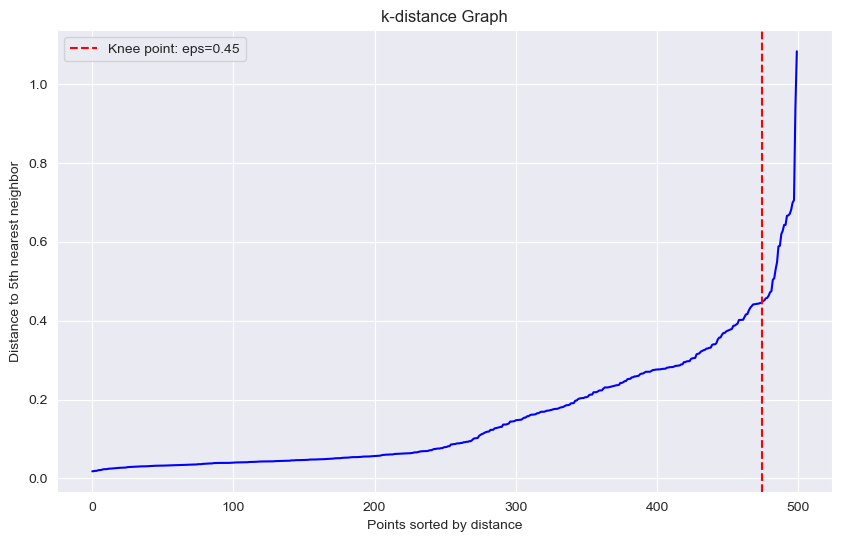


Determining optimal min_samples parameter:


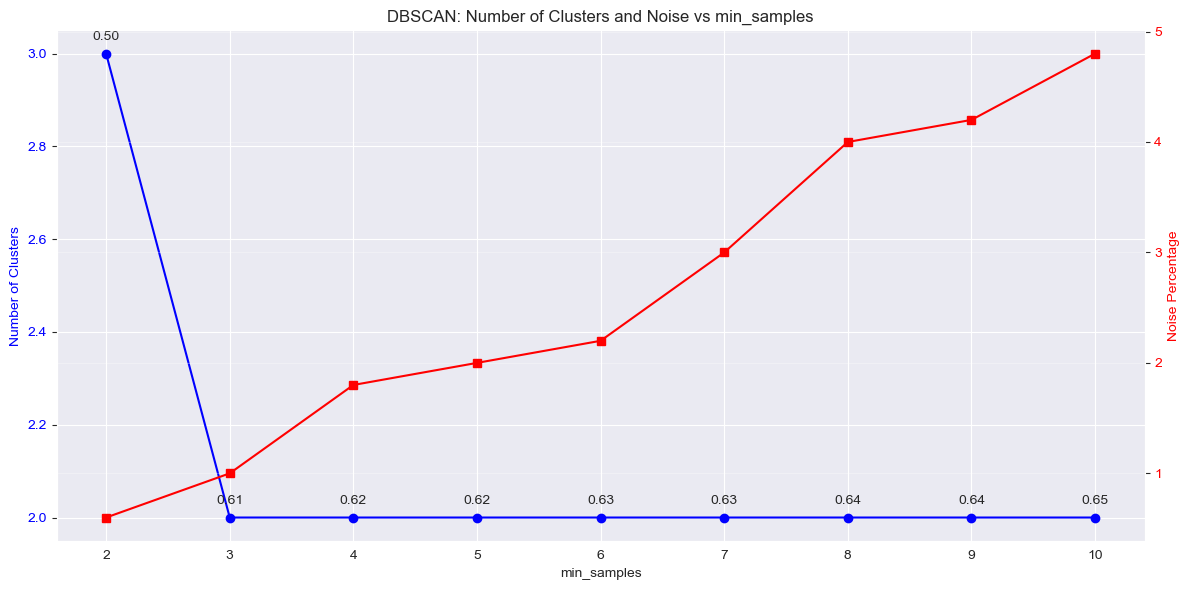

Recommended min_samples based on highest silhouette score: 10
Resulting in 2 clusters and 4.8% noise

Running DBSCAN with optimal parameters:

DBSCAN clustering results:


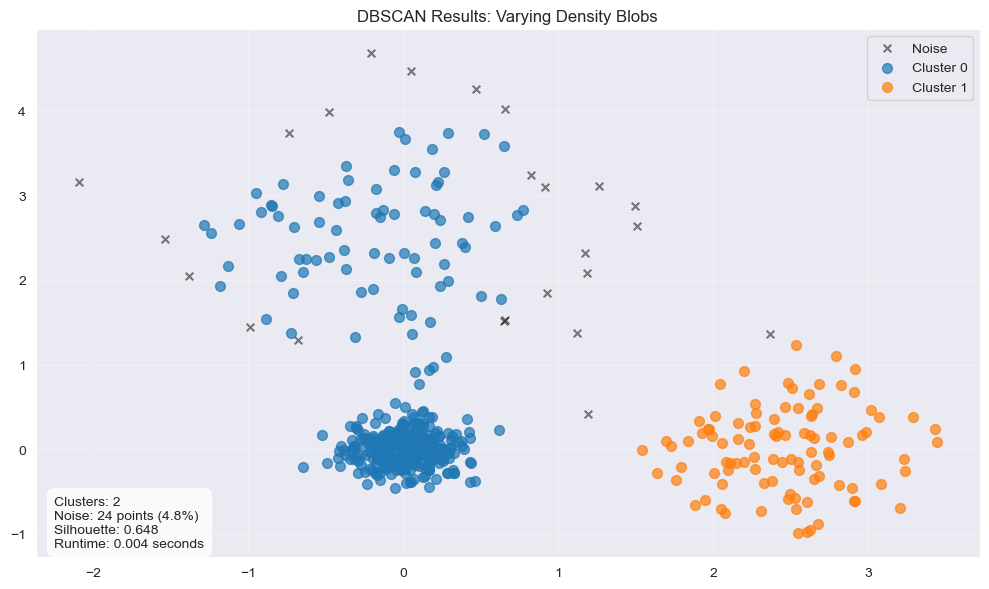


Adjusted Rand Index (compared to ground truth): 0.6043


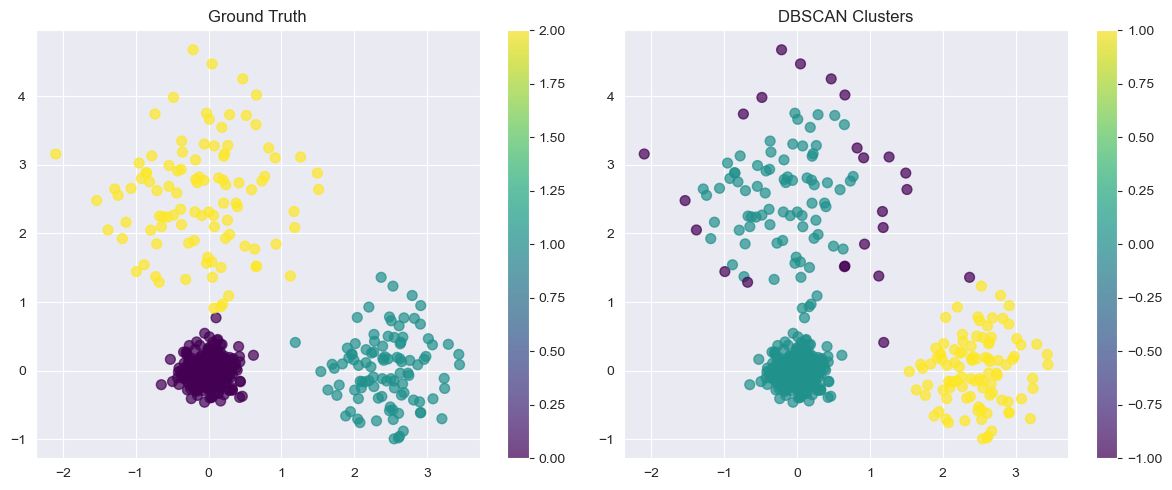


Parameter sensitivity analysis:


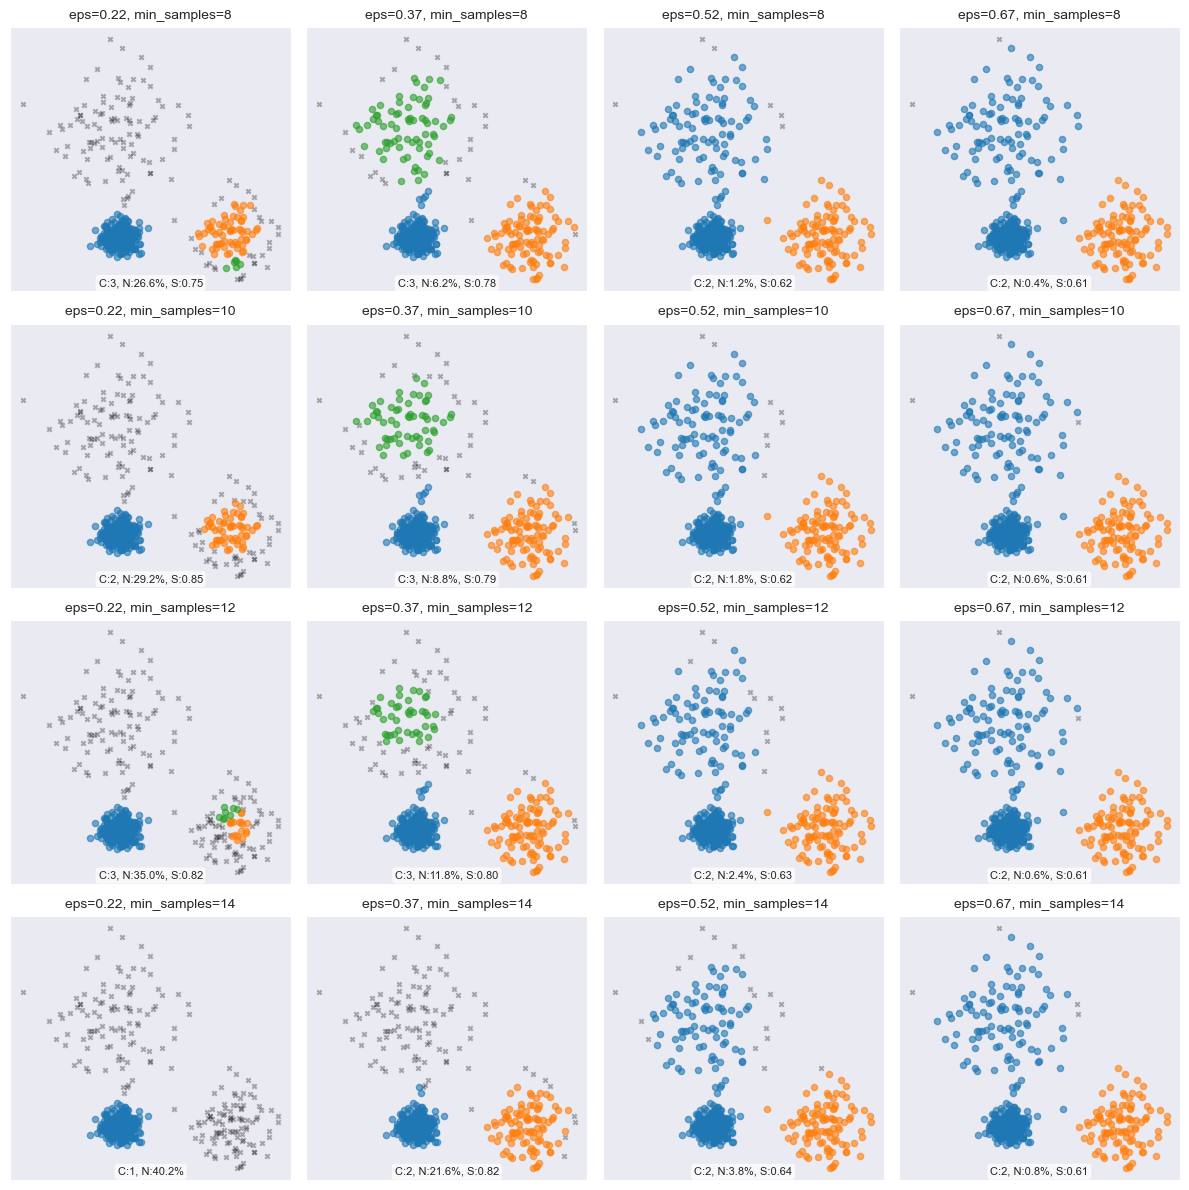

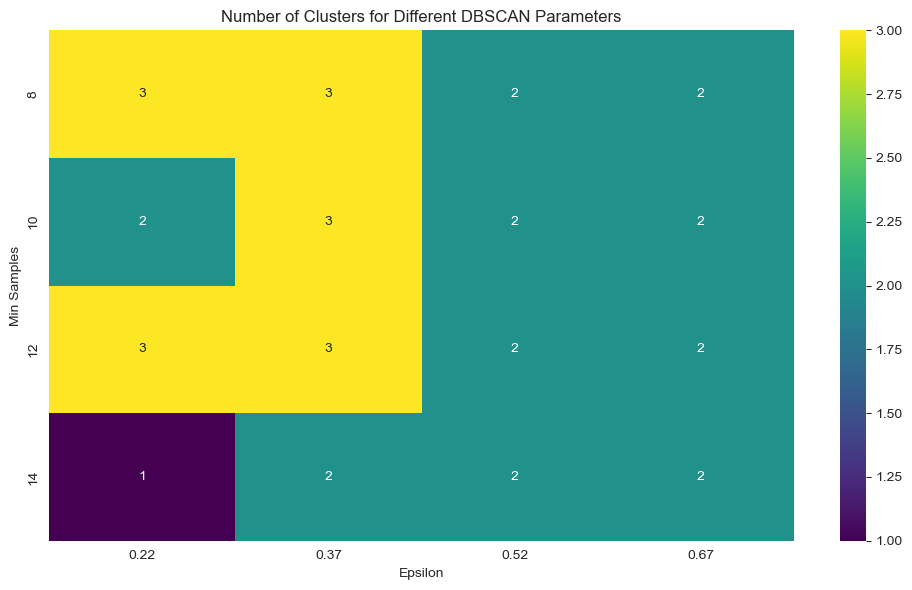

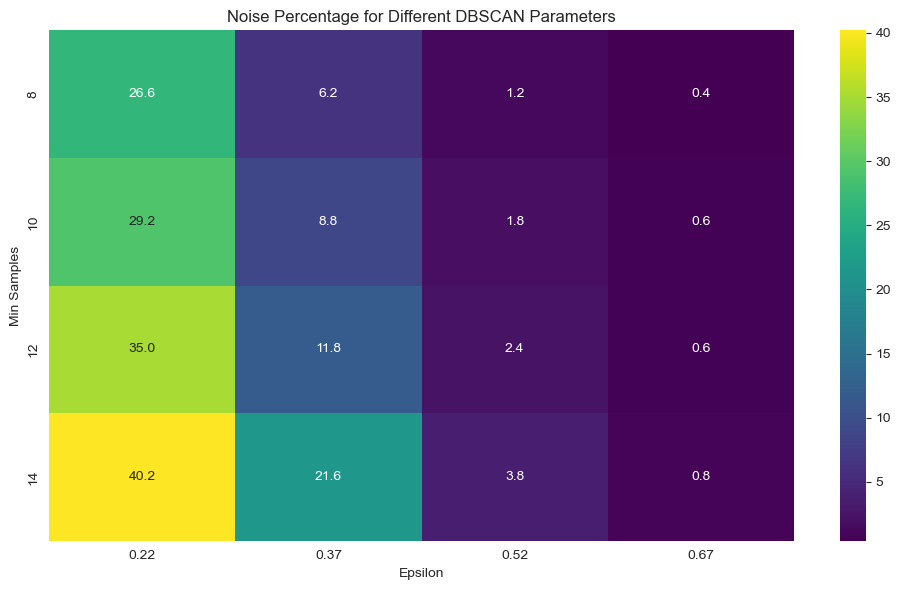

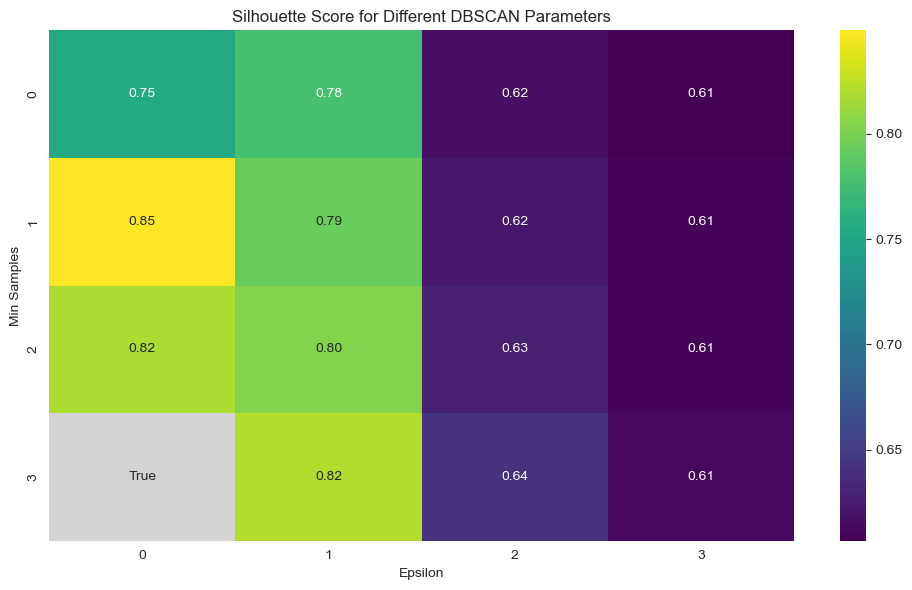

Best parameter combination based on composite score:
eps = 0.3710, min_samples = 8
Number of clusters: 3
Noise percentage: 6.2%
Silhouette score: 0.778

--------------------------------------------------
Dataset: Blobs with Outliers
--------------------------------------------------

Finding optimal epsilon using k-distance graph:
Optimal eps value (at knee point): 0.1033


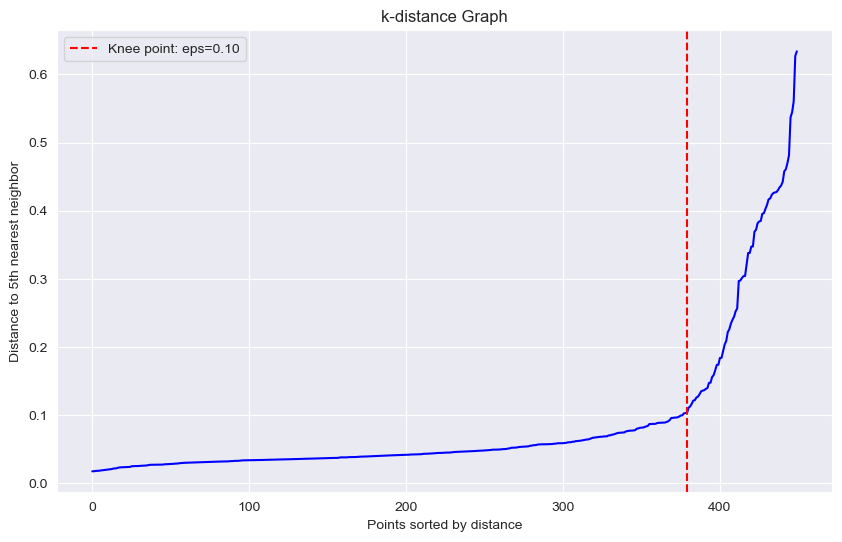


Determining optimal min_samples parameter:


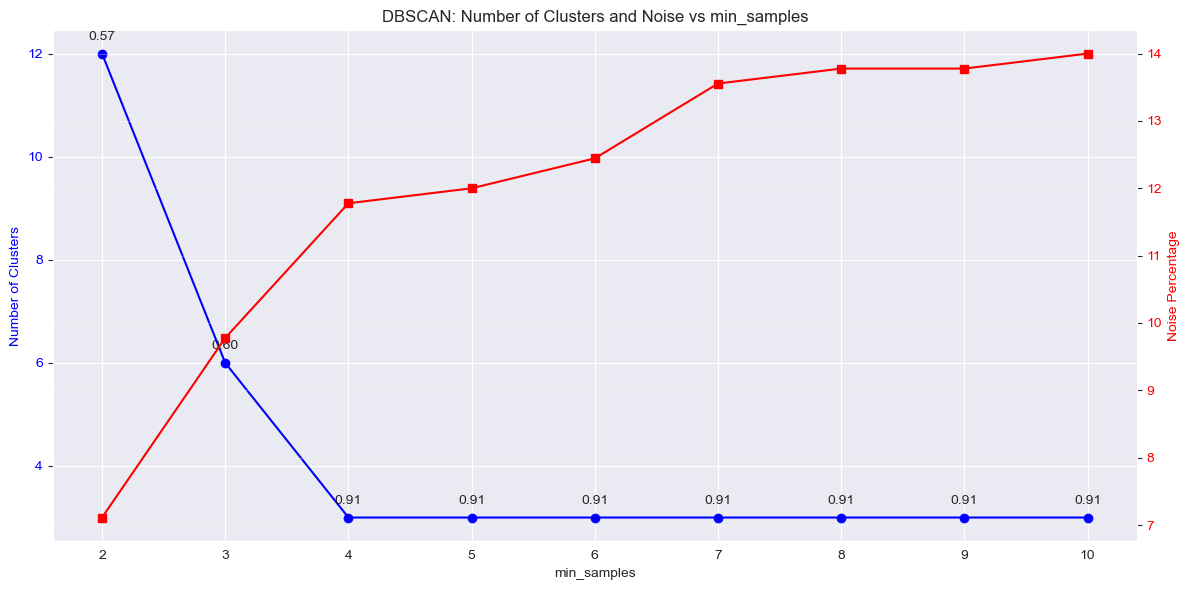

Recommended min_samples based on highest silhouette score: 10
Resulting in 3 clusters and 14.0% noise

Running DBSCAN with optimal parameters:

DBSCAN clustering results:


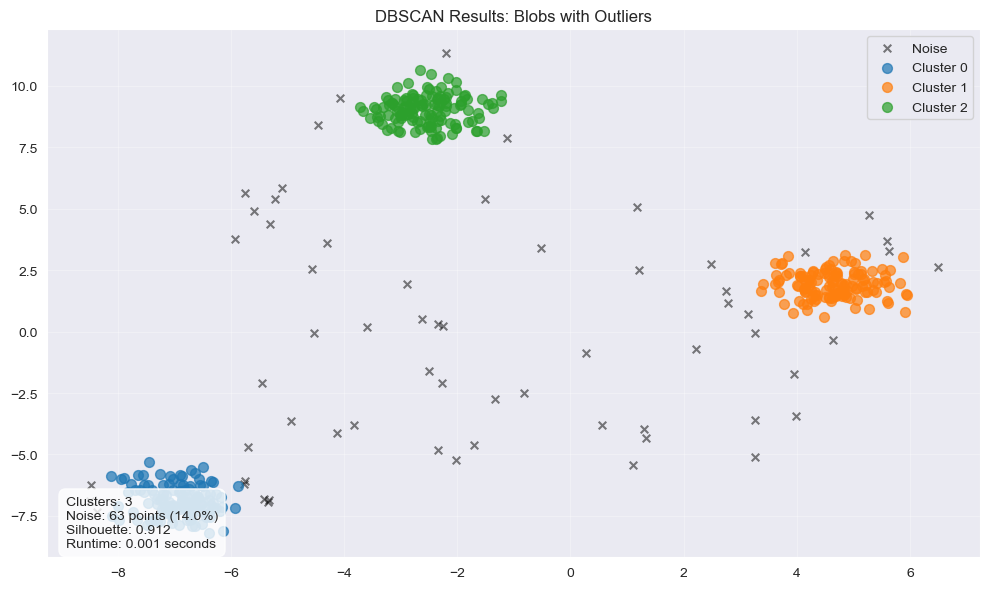


Adjusted Rand Index (compared to ground truth): 0.9320


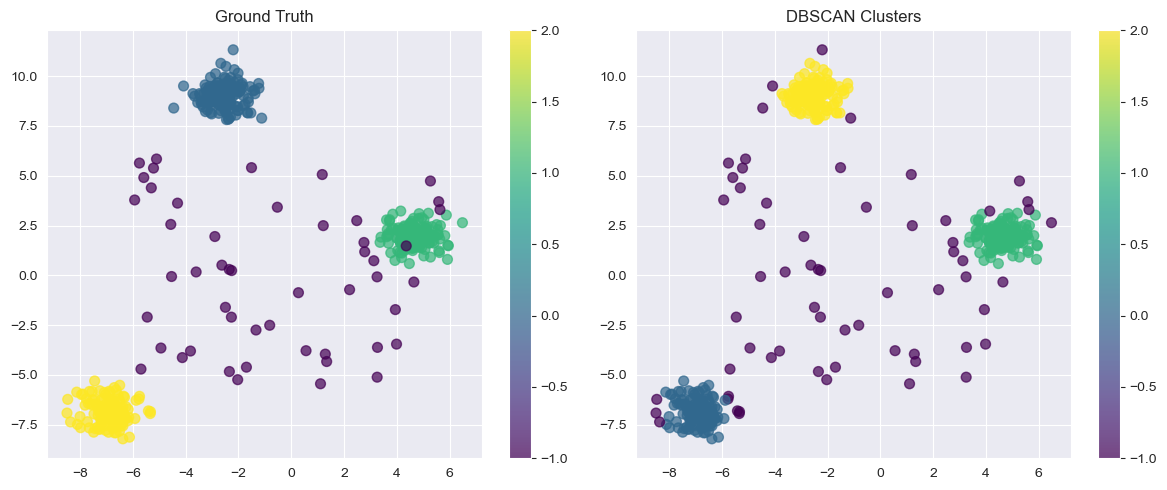


Parameter sensitivity analysis:


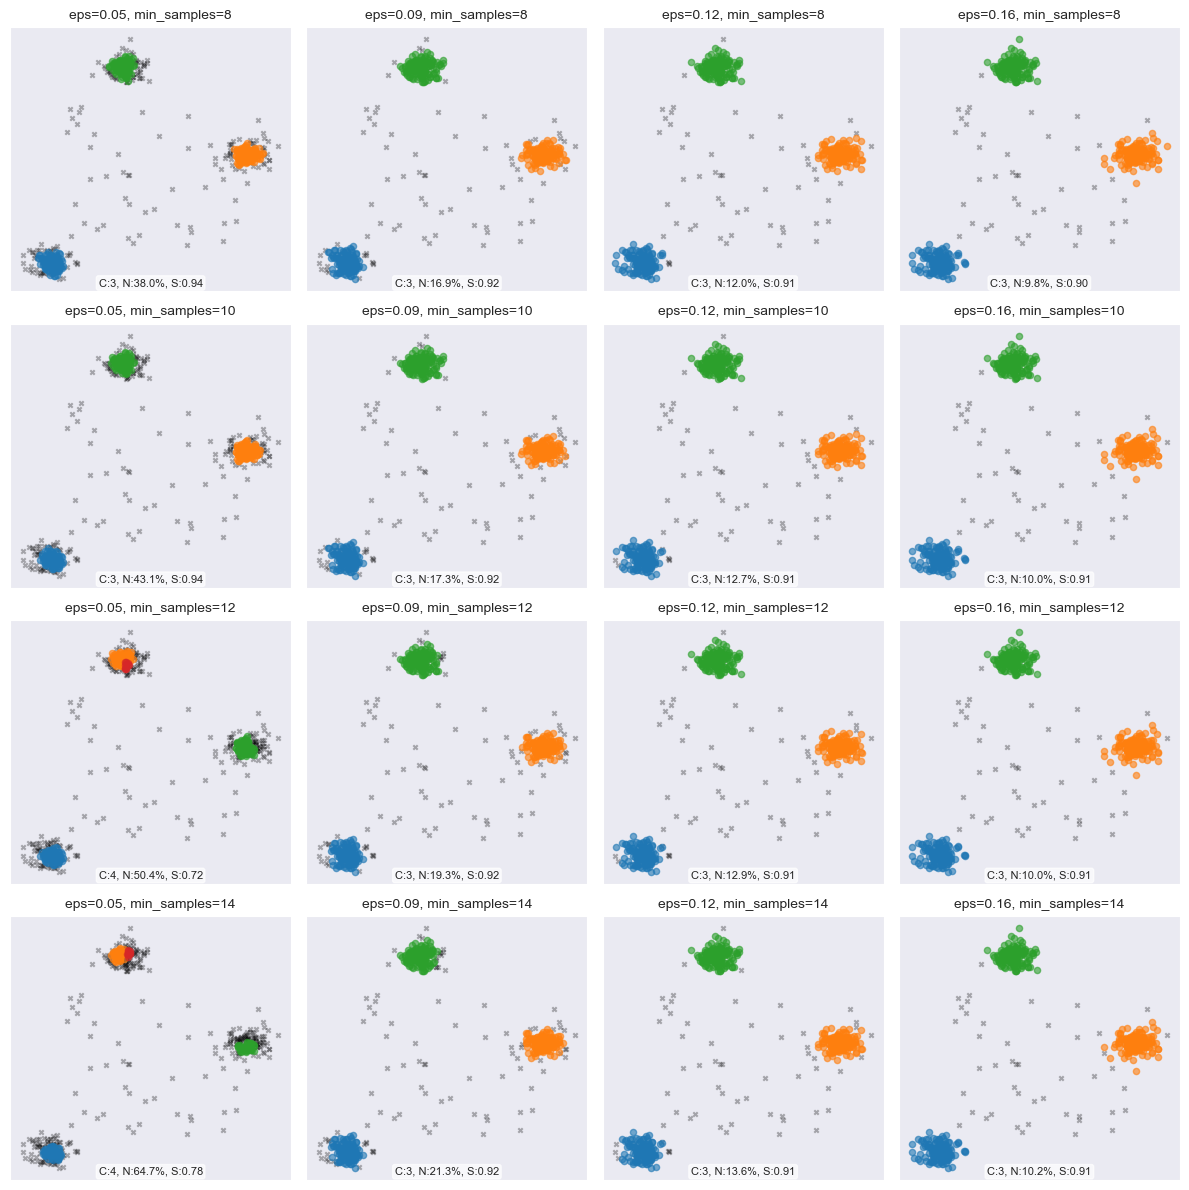

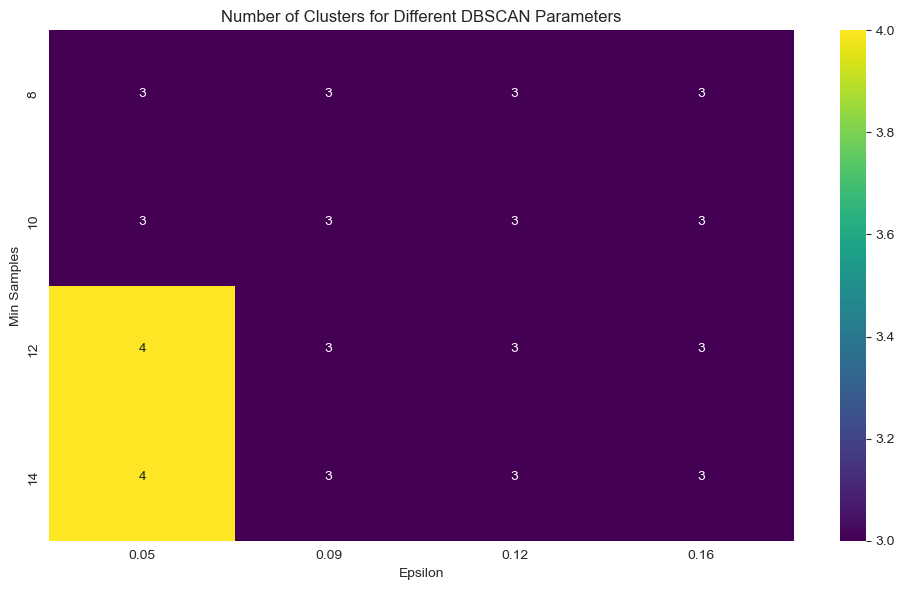

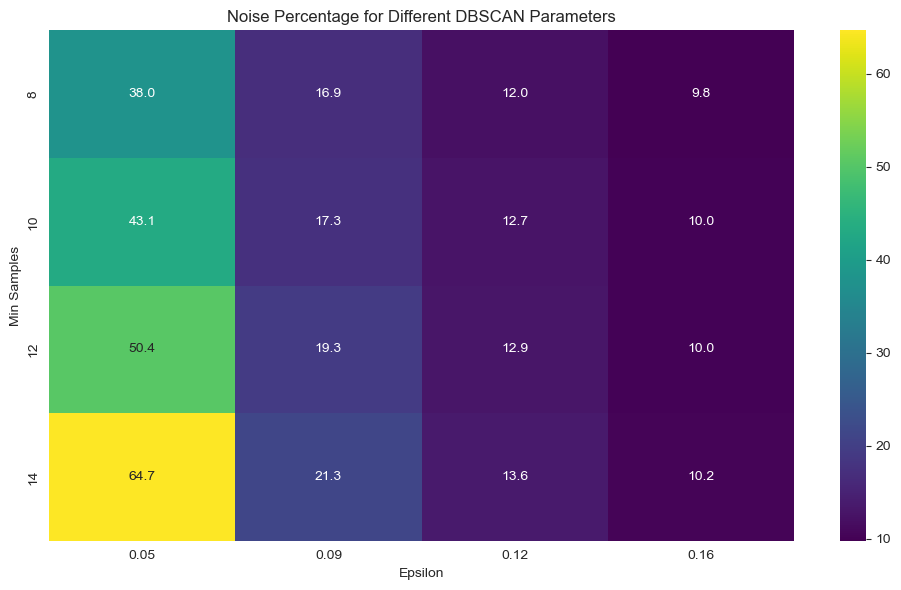

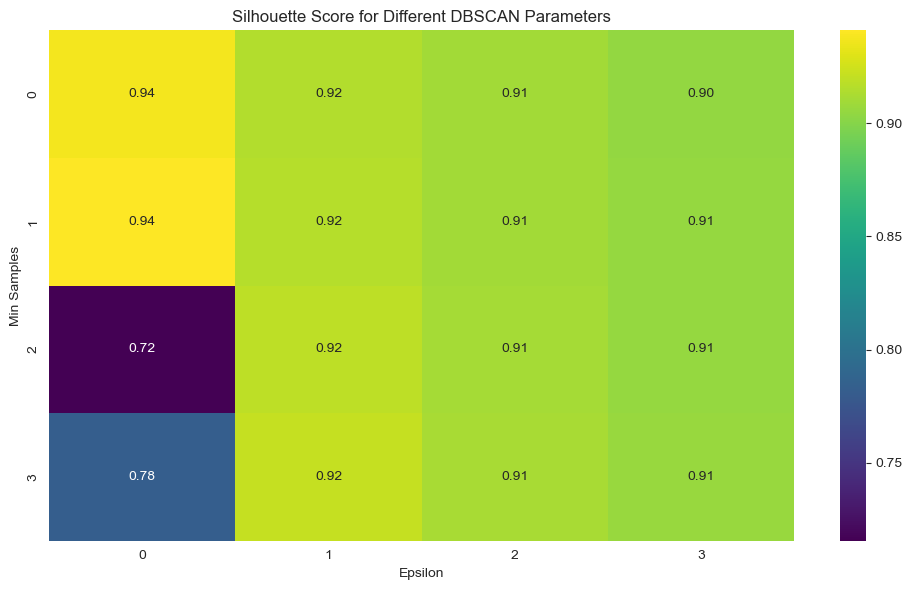

Best parameter combination based on composite score:
eps = 0.1550, min_samples = 8
Number of clusters: 3
Noise percentage: 9.8%
Silhouette score: 0.905

--------------------------------------------------
Dataset: Anisotropic Blobs
--------------------------------------------------

Finding optimal epsilon using k-distance graph:
Optimal eps value (at knee point): 0.0560


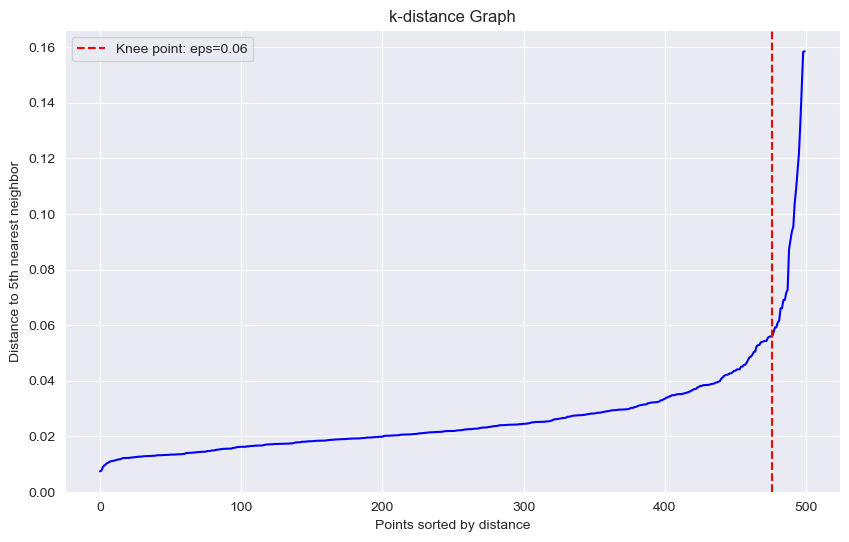


Determining optimal min_samples parameter:


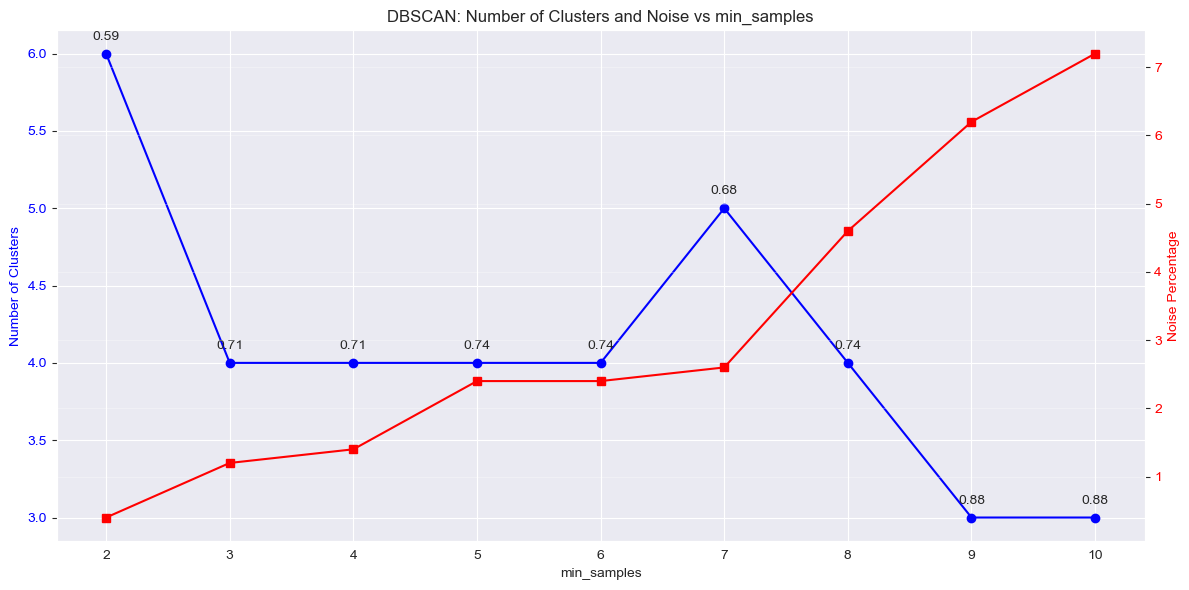

Recommended min_samples based on highest silhouette score: 10
Resulting in 3 clusters and 7.2% noise

Running DBSCAN with optimal parameters:

DBSCAN clustering results:


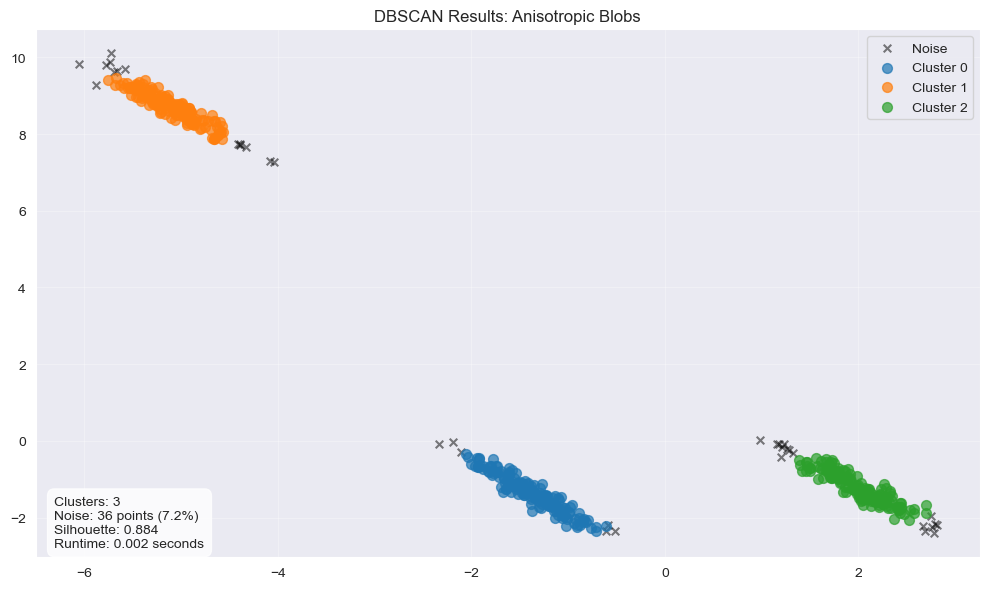


Adjusted Rand Index (compared to ground truth): 0.8895


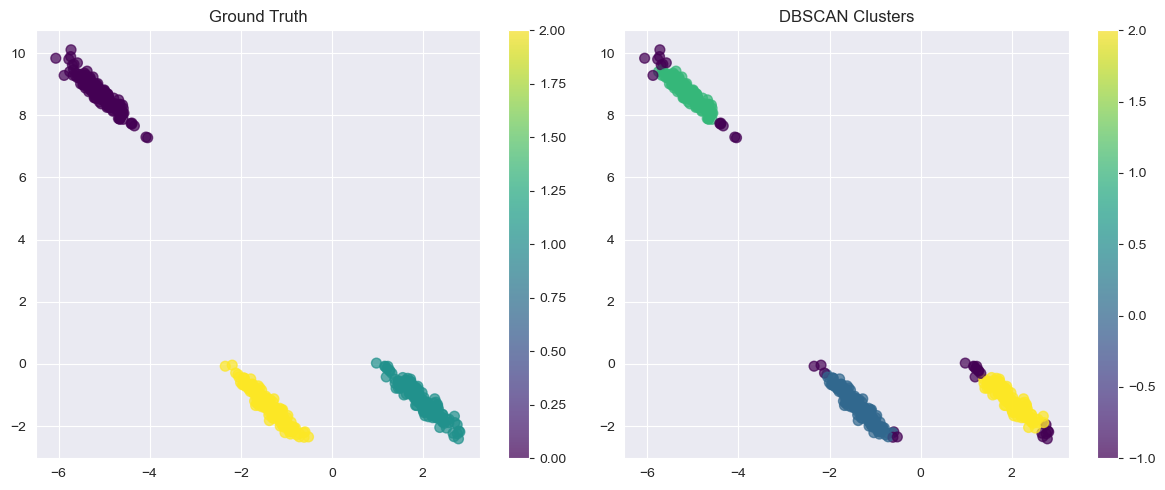


Parameter sensitivity analysis:


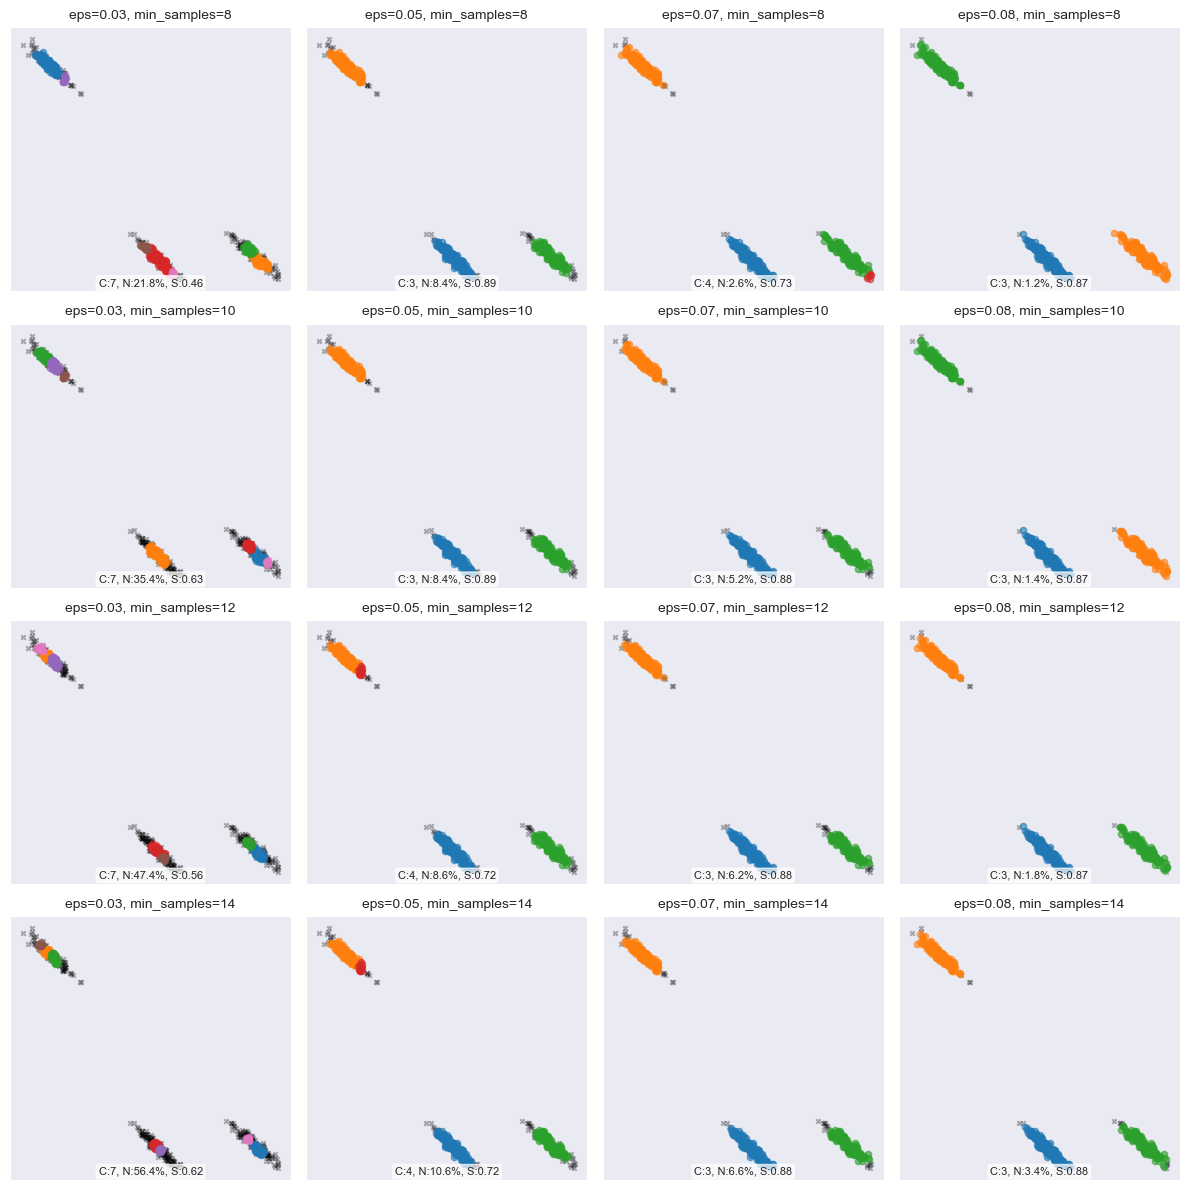

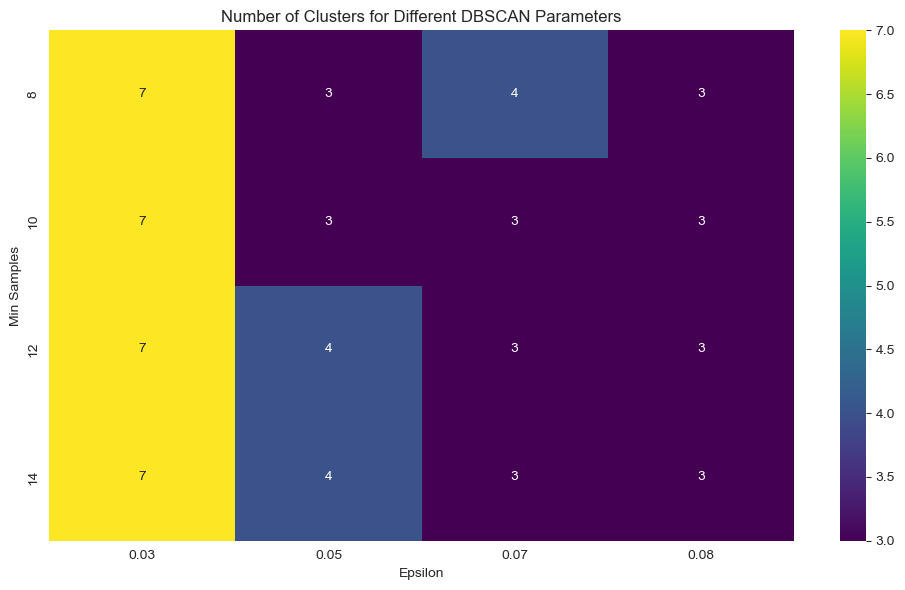

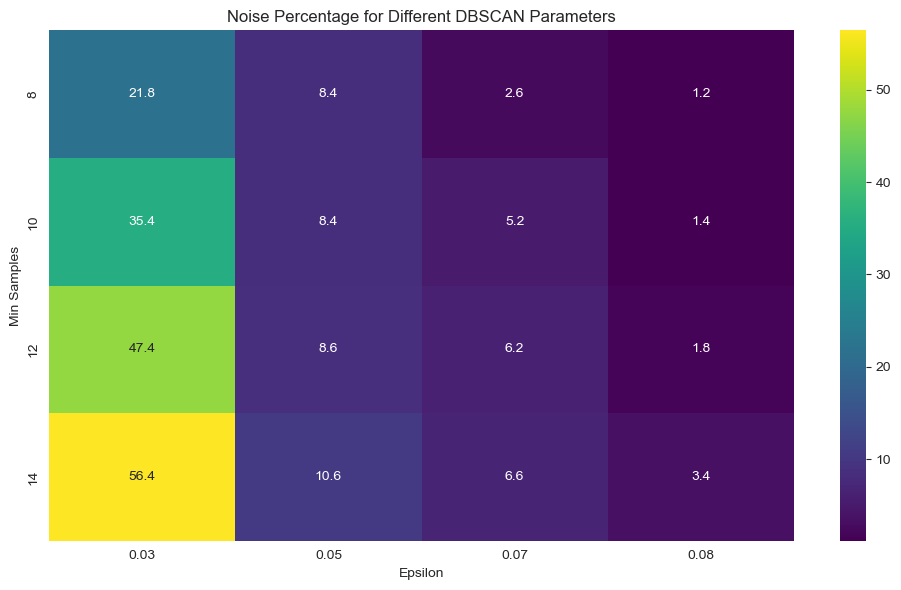

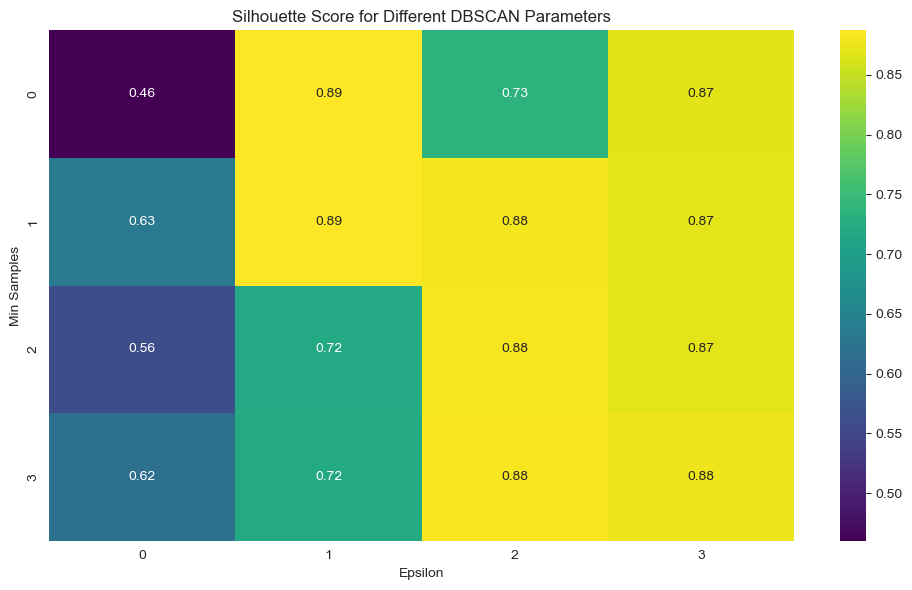

Best parameter combination based on composite score:
eps = 0.0839, min_samples = 8
Number of clusters: 3
Noise percentage: 1.2%
Silhouette score: 0.868

3. APPLYING DBSCAN TO A REAL-WORLD DATASET
Successfully loaded the Wholesale Customers dataset

Dataset Information:
Shape: (440, 8)

Feature Statistics:
       Channel  Region      Fresh      Milk   Grocery    Frozen  \
count   440.00  440.00     440.00    440.00    440.00    440.00   
mean      1.32    2.54   12000.30   5796.27   7951.28   3071.93   
std       0.47    0.77   12647.33   7380.38   9503.16   4854.67   
min       1.00    1.00       3.00     55.00      3.00     25.00   
25%       1.00    2.00    3127.75   1533.00   2153.00    742.25   
50%       1.00    3.00    8504.00   3627.00   4755.50   1526.00   
75%       2.00    3.00   16933.75   7190.25  10655.75   3554.25   
max       2.00    3.00  112151.00  73498.00  92780.00  60869.00   

       Detergents_Paper  Delicassen  
count            440.00      440.00  
mean         

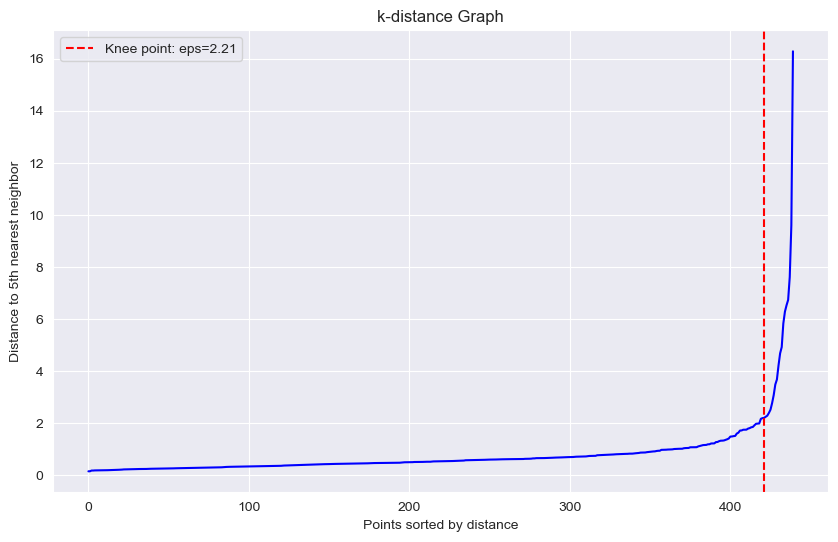

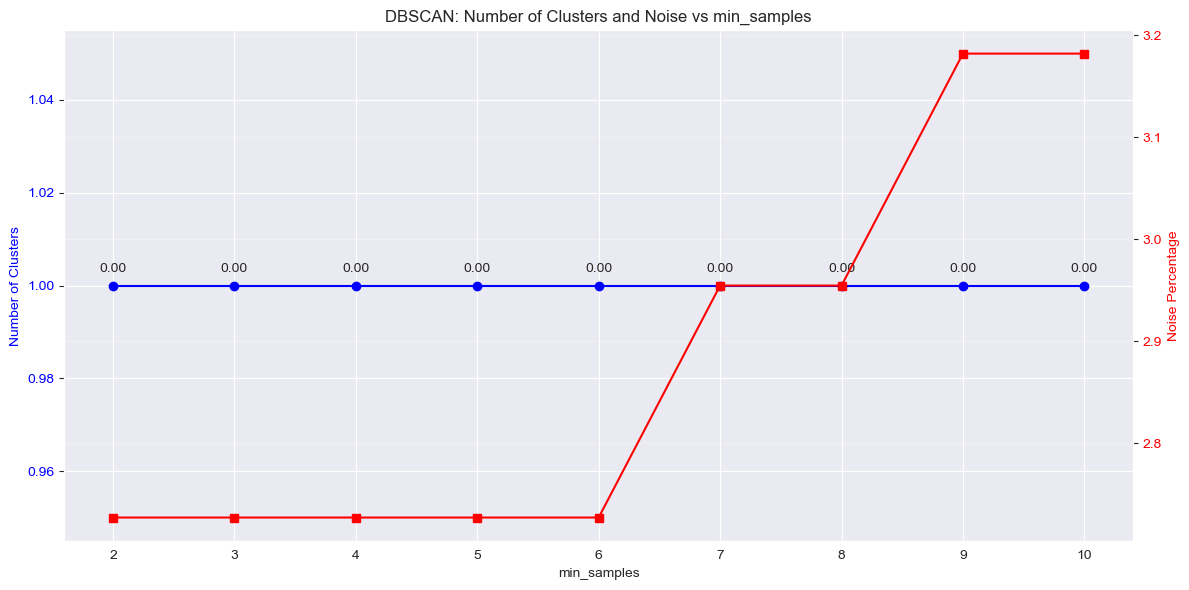

Couldn't determine optimal min_samples. Using default value of 5.

Running DBSCAN with optimal parameters...

Visualizing DBSCAN results with t-SNE...


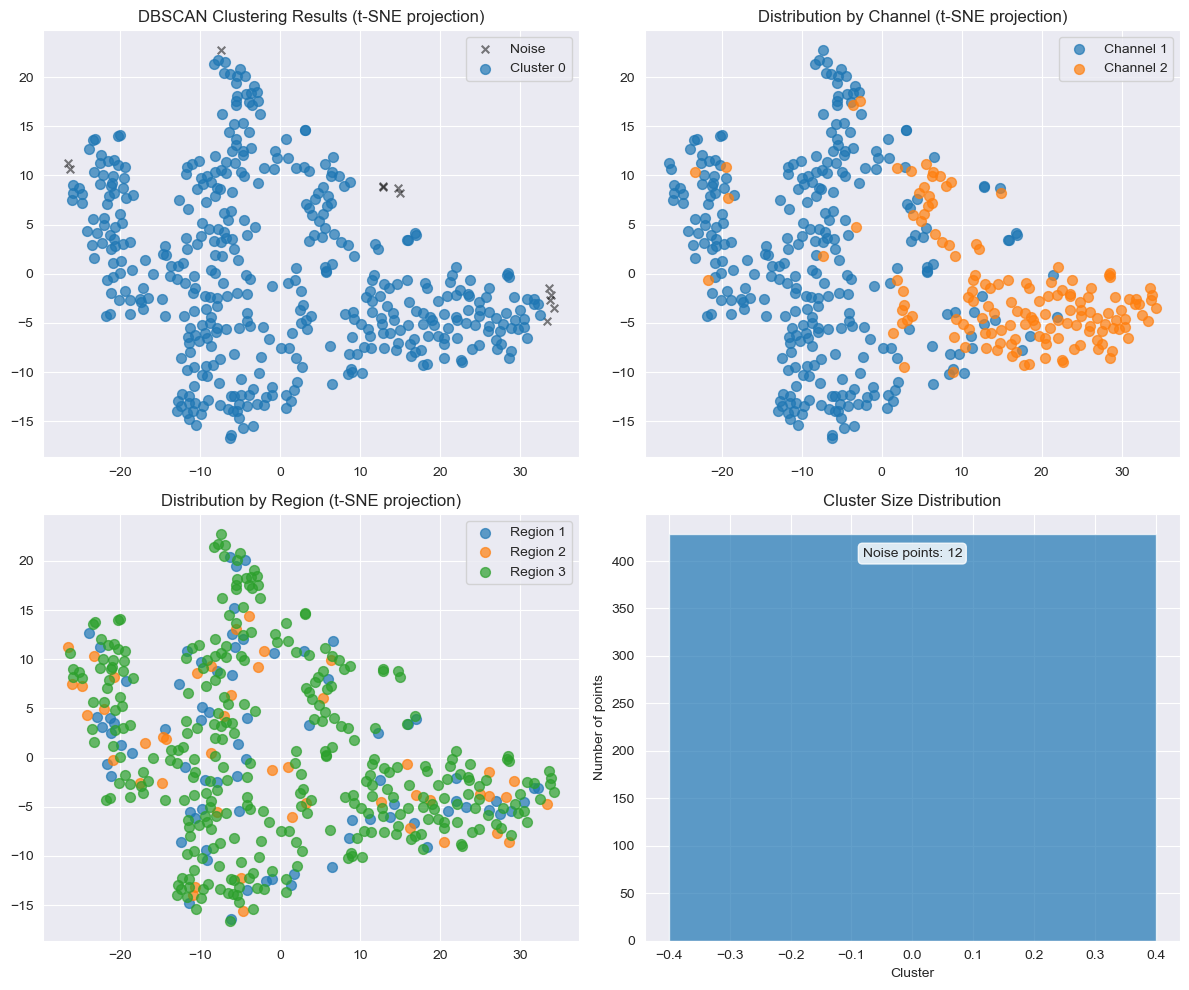


Cluster Analysis:

Cluster Means:
            Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
Cluster                                                                      
-1       34081.08  29455.67  34378.75  14931.33          13874.17    10307.50
 0       11381.21   5132.92   7210.32   2739.43           2573.29     1278.63


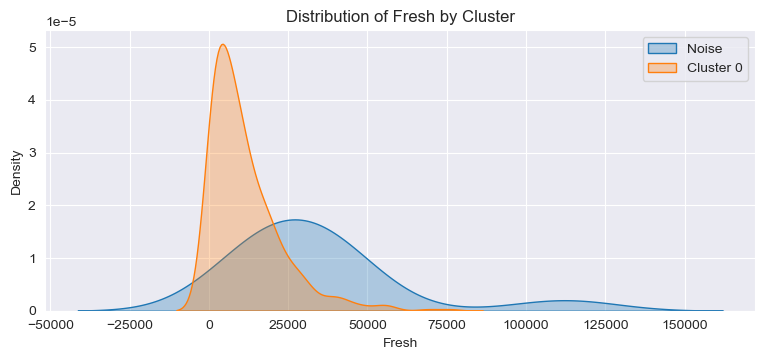

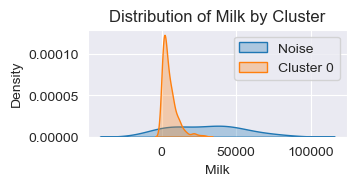

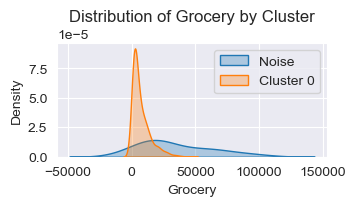

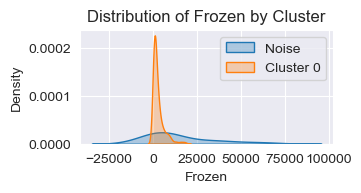

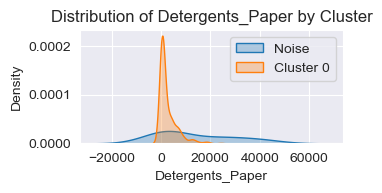

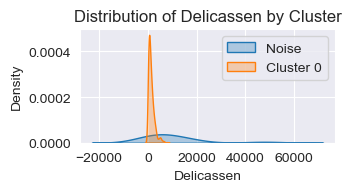


Channel Distribution within Clusters:
Channel      1      2
Cluster              
-1       50.00  50.00
 0       68.22  31.78


<Figure size 1000x600 with 0 Axes>

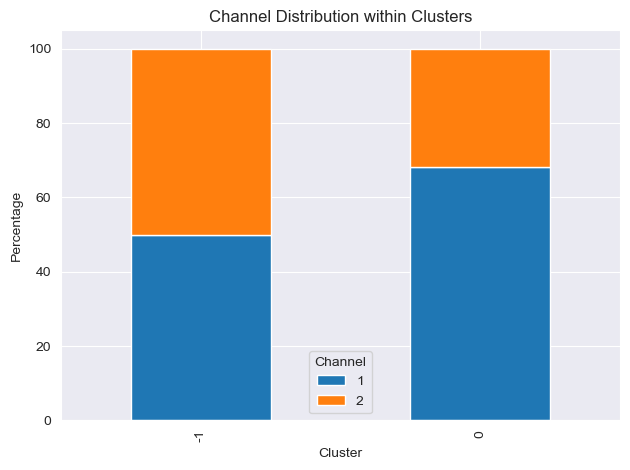


Region Distribution within Clusters:
Region       1      2      3
Cluster                     
-1        0.00  16.67  83.33
 0       17.99  10.51  71.50


<Figure size 1000x600 with 0 Axes>

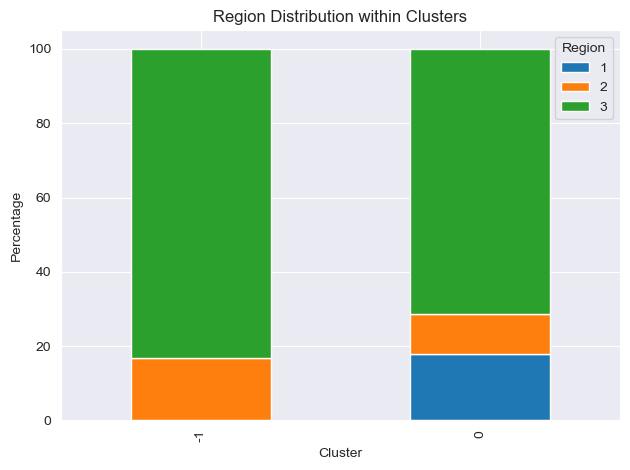

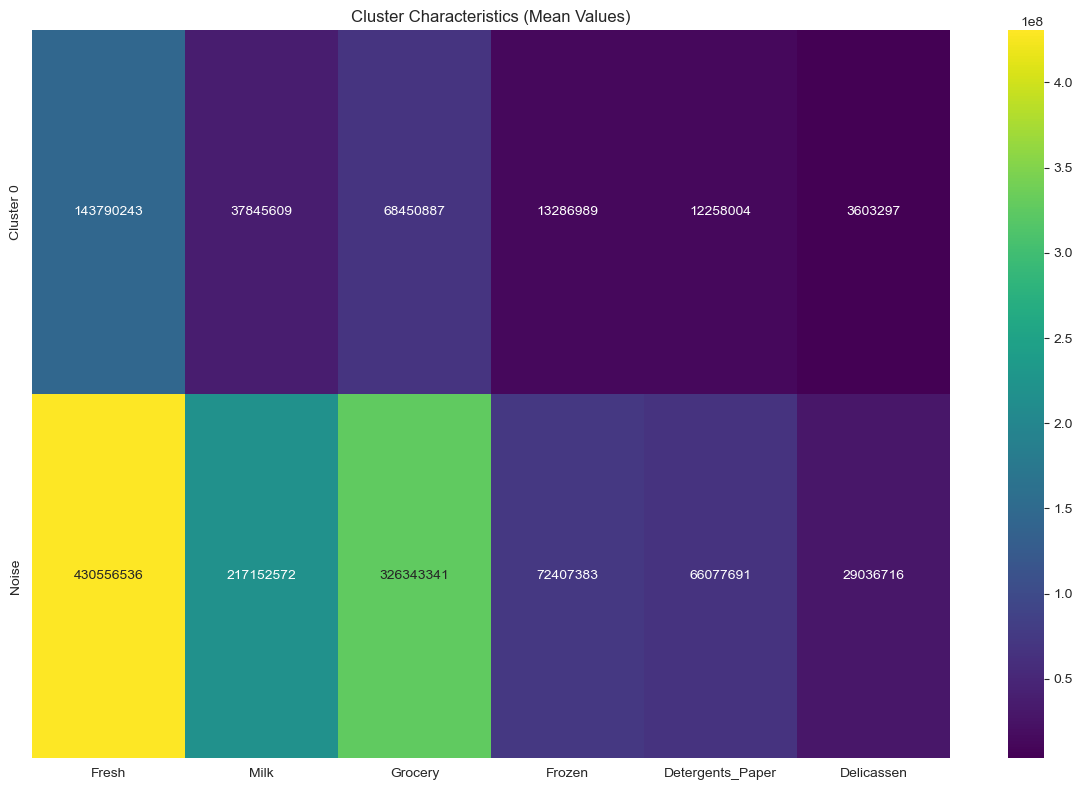


4. DBSCAN SUMMARY AND CONCLUSIONS

Advantages of DBSCAN:
- Does not require specifying the number of clusters beforehand
- Can find arbitrarily shaped clusters
- Robust to outliers (marks them as noise)
- Works well when clusters have varying densities (with appropriate parameters)

Limitations of DBSCAN:
- Sensitive to parameter selection (eps and min_samples)
- May struggle with clusters of varying densities
- Curse of dimensionality affects distance measurements
- Not ideal for high-dimensional data without dimensionality reduction

Best practices for DBSCAN:
1. Standardize or normalize your data before clustering
2. Use the k-distance graph to help identify an appropriate eps value
3. Set min_samples to at least the dimensionality of the data + 1
4. For high-dimensional data, consider dimensionality reduction first
5. Evaluate clustering quality with silhouette score or domain knowledge

Thank you for using the comprehensive DBSCAN implementation!


In [12]:
# Run the main function if this script is executed directly
if __name__ == "__main__":
    dbscan_main()